In [2]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas  # used to load metadata table
import numpy as np
import sys
import lmfit as lmfit
import glob as glob



import numpy as np
import os
from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm


import pandas as pd
import pickle
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from matplotlib import rc
import h5py
import os

from scipy import interpolate
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import midtools



Functions and variables for contrast

In [3]:
# variables
bs         = 11*1e-6    # beam size in m 
d         =  1.5e-3   # sample thickness in m
E         =  9        # Energy in keV
L         =  7   # sample-detector-distance in m
delLamLam =  5e-3     # Delta E over E: pink: 2e-3, in felix paper it is fixed at 5e-3 for some reason
P         =  200e-6    # pixel size in m



def calculate_M_det(E,q,delLamLam,bs,L,P,d):

    theta = calculate_theta(q,E)
    M_rad = calculate_M_rad(q,delLamLam,bs,E)
    M_det = np.sqrt(1+P**4*bs**2/(M_rad**2*(wavelength(E)* L)**4 )*( (bs**2)*np.cos(theta/2)**2+ (d**2)*np.sin(theta/2)**2) )

    return M_det


def calculate_M_rad(q,delLamLam,bs,E):
    theta=calculate_theta(q,E)
    M_rad=np.sqrt(1+(q**2)*(delLamLam**2)/(4*(np.pi)**2)*((bs**2)*(np.cos(theta))**2 + (d**2)*(np.sin(theta))**2 ))
    return M_rad


def speckle_contrast(E,q,delLamLam,bs,L,P,d):
    q=q*1e9
    beta = .5/(calculate_M_rad(q,delLamLam,bs,E)*calculate_M_det(E,q,delLamLam,bs,L,P,d))
    return beta

def wavelength(E):
    lam = 1.24/E*1e-9
    return lam


def calculate_theta(q,E):
    theta=np.arcsin(q/(4*np.pi/wavelength(E)))*2
    return theta



Functions for g2 definition and fitting

In [96]:
def calculate_g2(ttc):
    """Calculate the g2 function from a TTC
    """
    g2 = []
    dg2 = []
    ttc[ttc<.85]=np.nan
    ttc[ttc>1.1]=np.nan
    
    
    for i in range(1,ttc.shape[0]):
        g2.append(np.nanmean(np.diag(ttc, k=i)))
        dg2.append(np.nanstd(np.diag(ttc, k=i))/np.sqrt(len(np.diag(ttc, k=i))))
    return g2,dg2


def calculate_g2_weighted(ttc,err_ttc):
    """Calculate the g2 function from a TTC using errorbars on the ttcs
    """
    g2 = []
    dg2 = []

    #ttc[ttc<.9]=np.nan
    #ttc[ttc>1.1]=np.nan

    #err_ttc[ttc<.9]=np.nan
    #err_ttc[ttc>1.1]=np.nan

    w=1/err_ttc**2
    wx=ttc*w
    for i in range(1,ttc.shape[0]):

        g2.append(np.nansum(np.diag(wx, k=i))/np.nansum(np.diag(w, k=i)))
        dg2.append(np.sqrt(1/np.nansum(np.diag(w, k=i))))
    return g2,dg2



def exp_fun(x, A, tau,beta,inter):
    res = A * np.exp(-2*(x / tau) ** beta)+inter
    return res



def exp_qdep(x,kww,A,baseline,tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15):

    tau=np.array([tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15])
    
    t=x[:,0]
    qvalues=x[:,1]
    contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
    tau_new=np.repeat(tau,len(t)/15)
    result=A*contrast*np.exp(-(t/(tau_new))**kww_function(kww,qvalues))+baseline
    
    
    return(result)


def kww_function(kww,q):
    kww_new=(1-kww*q)

    return(kww_new)



def fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted,baseline_correction):


    colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))

    A, kww, baseline = (np.zeros([len(filenames)]) for i in range(3))
    dA, dkww, dbaseline = (np.zeros([len(filenames)]) for i in range(3))
    D,dD,tau,dtau=(np.zeros([len(filenames),qmax-qmin]) for i in range(4))

    data=np.load(f'{pathtodata}{filenames[0]}.npz')
    qvalues=data['q']


    #fit boundaries
    param_lowerboundary = list(np.array([  -.003, 0.999,  .9999 ]  +list(0*qvalues[qmin:qmax])).flatten())
    param_upperboundary = list(np.array([   .003, 1.001,  1.0001]  +list(0*qvalues[qmin:qmax]+500)).flatten())
    param_initialguess  = list(np.array([   0,        1,      1.]  +list(1/(2*qvalues[qmin:qmax]**2))  ).flatten())

    t_new=np.arange(1000)*.1
    t=np.arange(1,tmaxframes-tminframes)*t_delay

    qgrid=np.repeat(qvalues[qmin:qmax],len(t))
    times=np.array([t]*len(qvalues[qmin:qmax])).flatten()

    x=np.zeros([len(qgrid),2])
    x[:,0]=times
    x[:,1]=qgrid

    for i,namefile in enumerate(filenames):

        data=np.load(f'{pathtodata}{namefile}.npz')
        ttcs=data['ttcs']
        qvalues=data['q']
        if weighted==1:
            err_ttcs=data['err_ttcs']


        #contrast def
        bs=np.array(beamsize[i])
        contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)

        def exp_qdep(x,kww,A,baseline,tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15):
            tau=np.array([tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15])
            t=x[:,0]
            qvalues=x[:,1]
            contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
            tau_new=np.repeat(tau,len(t)/15)
            result=A*contrast*np.exp(-(t/(tau_new))**kww_function(kww,qvalues))+baseline
            return(result)

        if weighted!=1:
            allg2=[]
            alldg2=[]
            
            for q in range(qmin,qmax):
                g2,dg2=calculate_g2(ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes])
                dg2[-1]=.01
                allg2.append(g2)
                alldg2.append(dg2)

        if weighted==1:
            allg2=[]
            alldg2=[]
    
            for q in range(qmin,qmax):
                g2,dg2=calculate_g2_weighted(ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes],err_ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes])
                allg2.append(g2)
                alldg2.append(dg2)
                        
        if baseline_correction==1:
            for q in range(7,qmax):
                allg2[q]=allg2[q]-np.nanmean(allg2[q][-10:-2])+1

        y=np.array(allg2).flatten()
        dy=np.array(alldg2).flatten()
        popt, pcov = curve_fit(exp_qdep, xdata=x, ydata=y, sigma=dy,
                        bounds=(param_lowerboundary,
                                    param_upperboundary),
                                p0=param_initialguess )
        #save fit parameters
        kww[i]= popt[0]
        dkww[i] = np.sqrt(np.diag(pcov))[0]
        A[i] = popt[1]
        dA[i] = np.sqrt(np.diag(pcov))[1]
        baseline[i]= popt[2]
        dbaseline[i] = np.sqrt(np.diag(pcov))[2]

        for n,j in enumerate(range(3,len(popt))):
            tau[i,n]= popt[j]
            dtau[i,n] = np.sqrt(np.diag(pcov))[j]
            D[i,n]=1/tau[i,n]/qvalues[n]**2
            dD[i,n]=1/tau[i,n]**2*dtau[i,n]/qvalues[n]**2
            
        
        #plot fit
        for qshift in range (1):
            fig1=plt.figure(figsize=(8,4))
            for j,q in enumerate(range(qmin+qshift,qmax)):
                x_new=t_new
                y_new=contrast[q]*np.exp(-(t_new/(tau[i,q]))**kww_function(kww[i],qvalues[q]))+baseline[i]
                
                plt.subplot(1,2,1)
                plt.errorbar(t,allg2[j] ,alldg2[j],marker='o',ls=' ',color=colore[q-qmin],
                    label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black',markersize=6,alpha=.9,)
                plt.plot(x_new,y_new,color=colore[q-qmin],linestyle='dashed')
                
                plt.subplot(1,2,2)
                plt.errorbar(t,(allg2[q]-baseline[i])/(contrast[q]*A[i]) ,alldg2[q]/(contrast[q]*A[i]),marker='o',ls=' ',markersize=6,alpha=.9,
                    color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black')
                plt.plot(x_new, (y_new-baseline[i])/(contrast[q]*A[i]), linestyle='dashed',color=colore[q-qmin])
                    
            plt.xscale('log')
            plt.grid('on')
            plt.ylim([-.1,1.05])
            plt.xlabel('$t$ (μs)')
            plt.ylabel('$(g_2(t,q)-b)/contrast$')
            plt.tight_layout()

            plt.subplot(1,2,1)
            #plt.legend(loc='upper right')
            plt.xscale('log')
            plt.xlim([.09, 500])
            plt.grid('on')
            #plt.ylim([1-0.005,1.081])
            plt.xlabel('$t$ (μs)')
            plt.ylabel('$g_2 (t,q)$')
            plt.tight_layout()
            plt.figure(fig1)
            plt.title(f' {namefile}')

    return(qvalues, A, kww, baseline, tau, D, contrast,dA, dkww, dbaseline,dD,dtau)



def plot_sameq(filenames,qval,tminframes,tmaxframes,weighted,baseline_correction):

    
    colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))
    data=np.load(f'{pathtodata}{filenames[0]}.npz')
    qvalues=data['q']
    
    for q in qval:

        fig1=plt.figure(figsize=(6,6))
        for i,namefile in enumerate(filenames):

            data=np.load(f'{pathtodata}{namefile}.npz')
            ttcs=data['ttcs']
            qvalues=data['q']

            t_new=np.arange(1000)*.1
            t=np.arange(1,tmaxframes-tminframes)*t_delay

            
            g2,dg2=calculate_g2(ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes])
            dg2[-1]=.05
            
            if weighted==1:
                        err_ttcs=data['err_ttcs']
                        
                        g2,dg2=calculate_g2_weighted(ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes],err_ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes])
                        
            #plot 
            if baseline_correction:
                g2=g2-np.nanmean(g2[-10:-2])+1

            plt.errorbar(t,g2,dg2,marker='o',ls=' ',color=colore_files[i],
                        label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black',markersize=6,alpha=.9,)
                


            #plt.legend(loc='upper right')
            plt.xscale('log')
            plt.xlim([.09, 500])
            plt.grid('on')
            plt.title('$q$='+str(qvalues[q])+'nm$^{-1}$')
            #plt.ylim([1-0.005,1.081])
            plt.xlabel('$t$ (μs)')
            plt.ylabel('$g_2 (t,q)$')
            plt.tight_layout()
            

    return()

In [5]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9/p003094/'

##### Filters for position and energy

In [6]:
namefile='c_70_abs2_RT'
t_delay=.44

data=np.load(f'{pathtodata}{namefile}.npz')
ttcs=data['ttcs']
qvalues=data['q']

bin_centers_std=data['bin_centers_std'][:]
n_std_all=data['n_std_all'][:]
high_std_threshold_all=data['high_std_threshold_all'][:],

bin_centers_mean=data['bin_centers_mean'][:],
n_mean_all=data['n_mean_all'][:],
minttcmean=data['minttcmean'],
maxttcmean=data['maxttcmean'],

bin_centers_energy=data['bin_centers_energy'][:],
n_energy=data['n_energy'][:],
min_energy=data['min_energy'],
max_energy=data['max_energy'],

maxpositionz=data['maxpositionz'],
minpositionz=data['minpositionz'],

maxposition=data['maxposition'],
minposition=data['minposition'],

position_filter=data['position_filter'],

n_tot_files=data['n_tot_files']

print(r'data loaded')


data loaded


### TTCs 120 mg/ml, different attenuation at q=0.45 1/nm

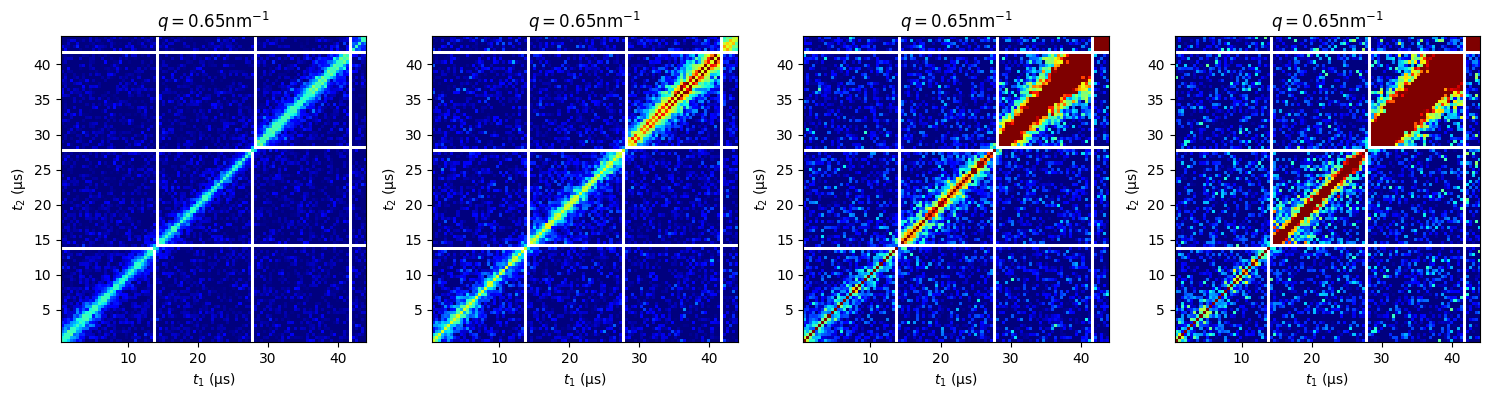

In [9]:

filenames=['c_120_abs4_RT_errorbars','c_120_abs2_RT_errorbars','c_120_abs1_RT_errorbars','c_120_absp6_RT']
colore=plt.cm.jet(np.linspace(0,1,len(filenames)))

t_delay=.44
q=13
tot_frames=100

fig=plt.figure(figsize=(15,10))
for i,namefile in enumerate(filenames):
    data=np.load(f'{pathtodata}{namefile}.npz')
    ttcs=data['ttcs']
    qvalues=data['q']

    plt.subplot(1,4,i+1)
    plt.imshow(ttcs[q,:,:],origin='lower',cmap='jet',vmin=1,vmax=1.05,extent=(t_delay,t_delay*tot_frames,t_delay,t_delay*tot_frames,),interpolation='none')
    plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    plt.tight_layout()
    plt.ylabel('$t_2$ (μs)')
    plt.xlabel('$t_1$ (μs)')

    if i==len(namefile)-1:
        plt.colorbar()
    


### fit g2 120 mg/ml different attenuations

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

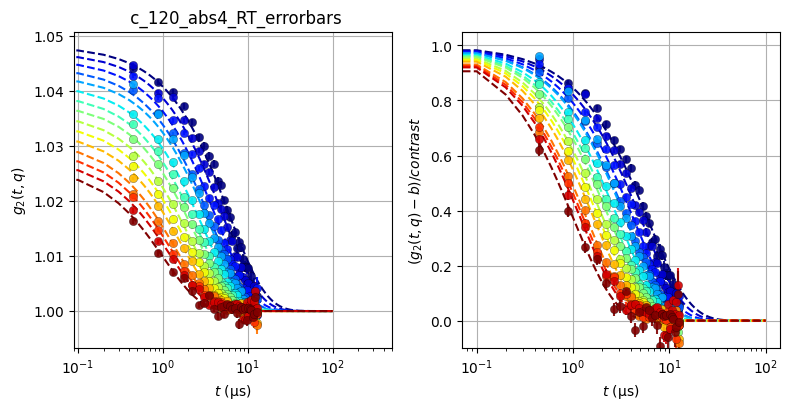

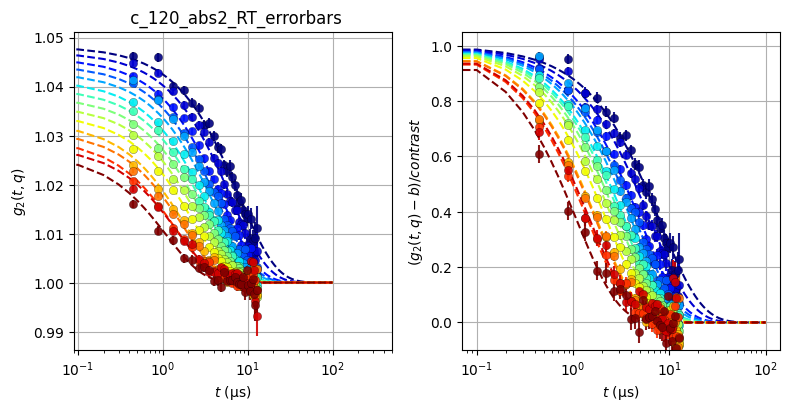

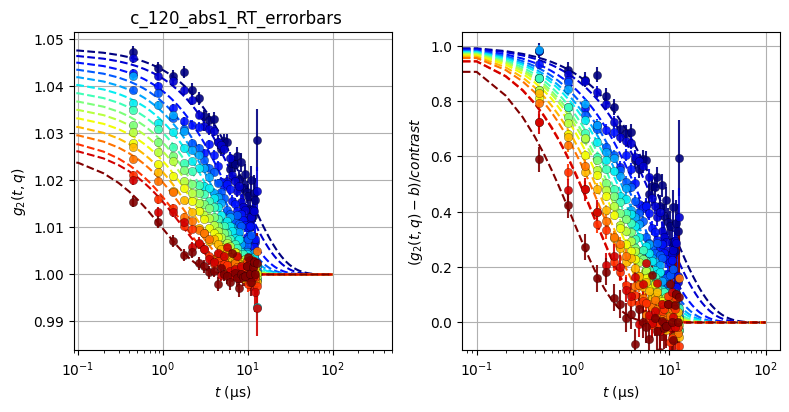

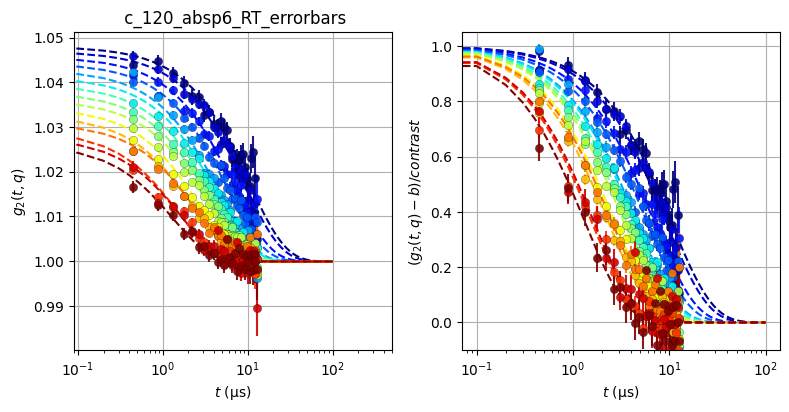

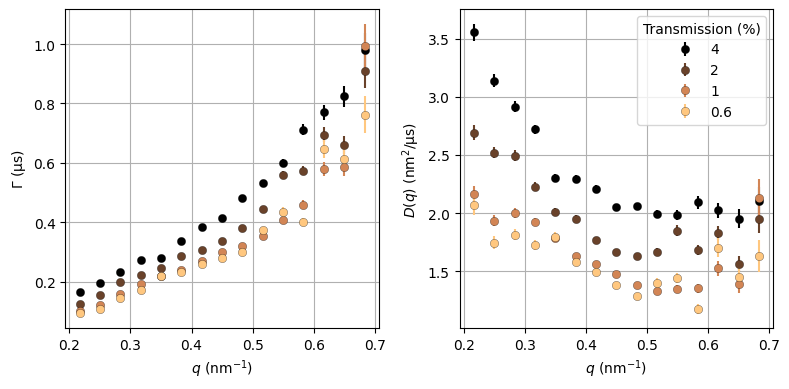

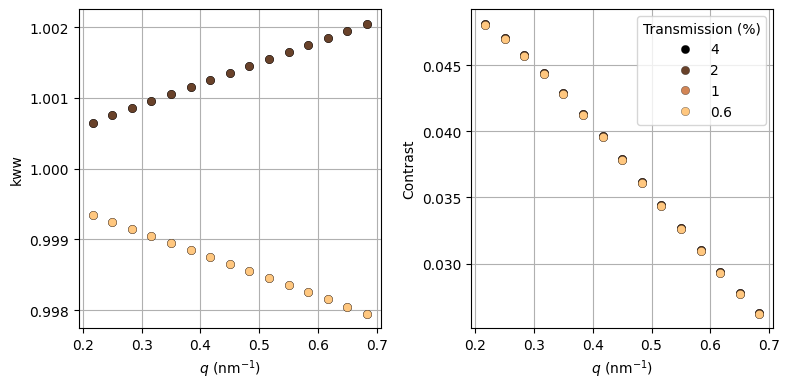

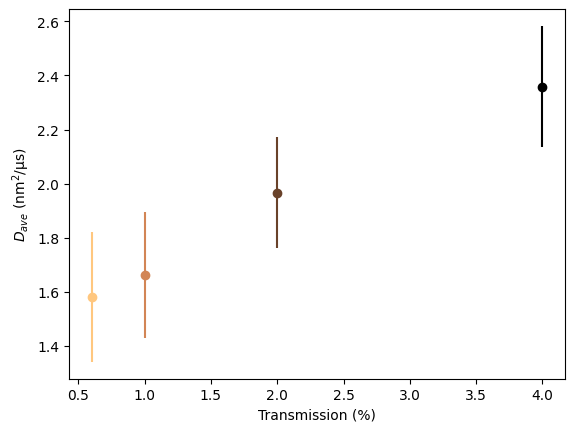

In [192]:
filenames=['c_120_abs4_RT_errorbars','c_120_abs2_RT_errorbars','c_120_abs1_RT_errorbars','c_120_absp6_RT_errorbars']
transmission=[4,2,1,.6]
concentration=[120,120,120,120]
bs=15e-6


tminframes=0
tmaxframes=30
qmin=0

qmax=15
beamsize=[15e-6,15e-6,15e-6,15e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0  )

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend([4,2,1,0.6],title='Transmission (%)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],A[i]*contrast,marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend([4,2,1,0.6],title='Transmission (%)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(transmission[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_files[i])
plt.xlabel('Transmission (%)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')





# fit g2 70 mg/ml different attenuations

()

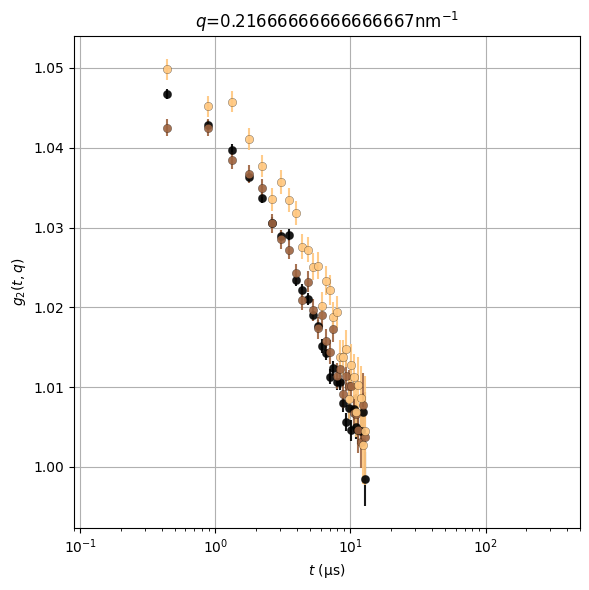

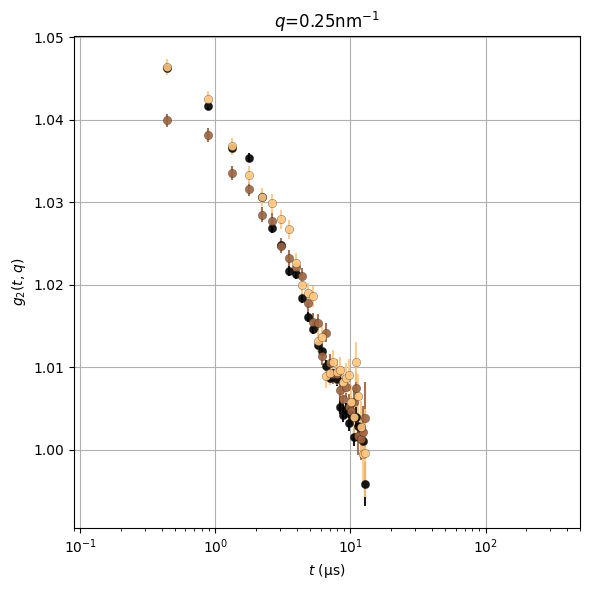

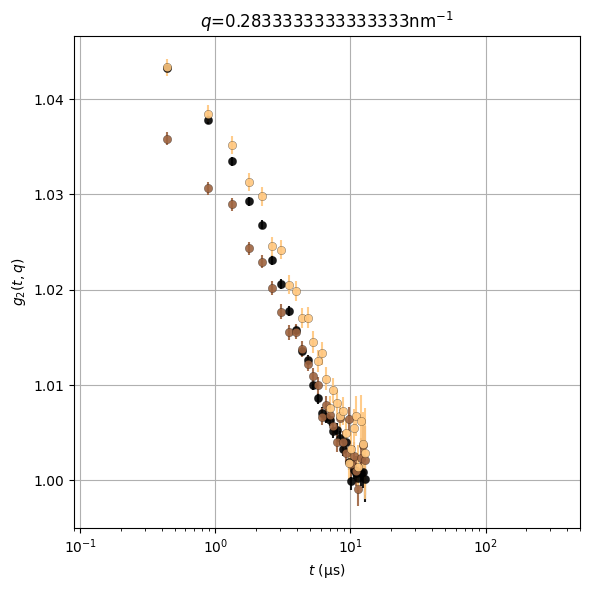

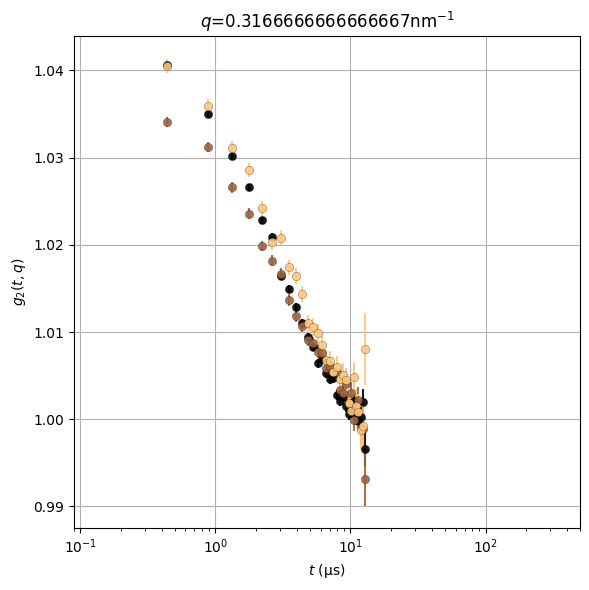

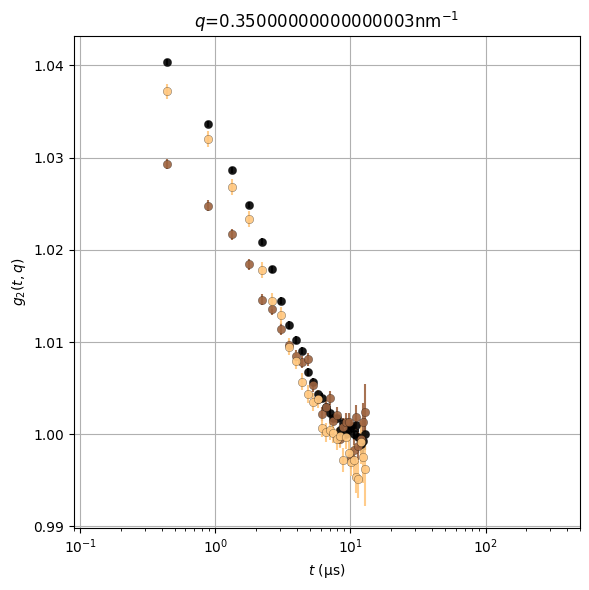

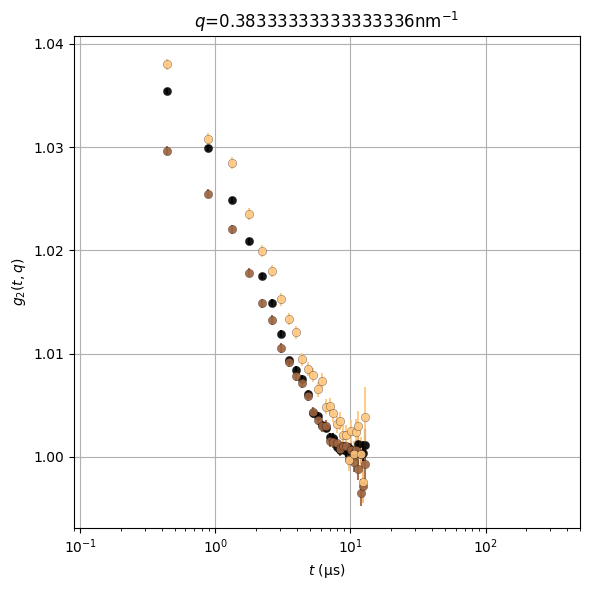

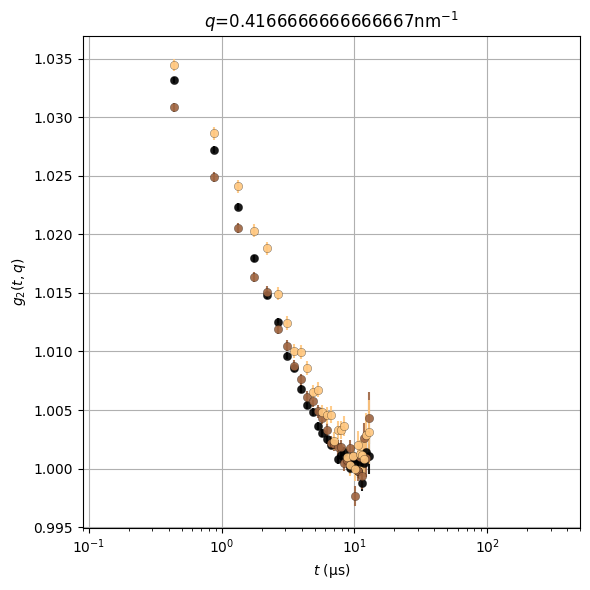

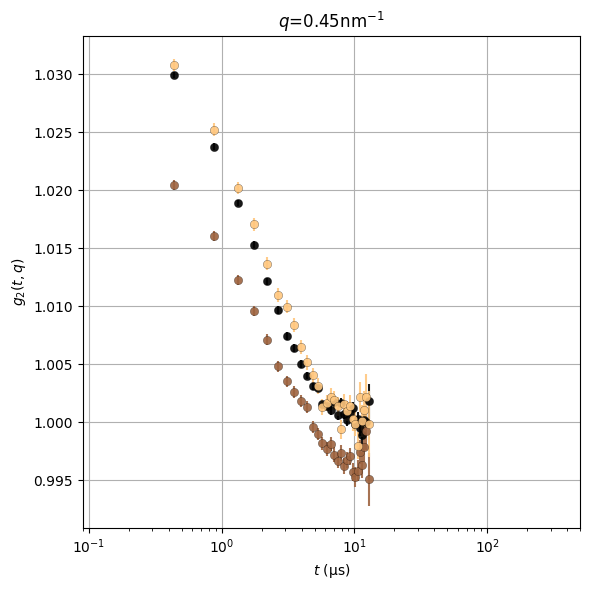

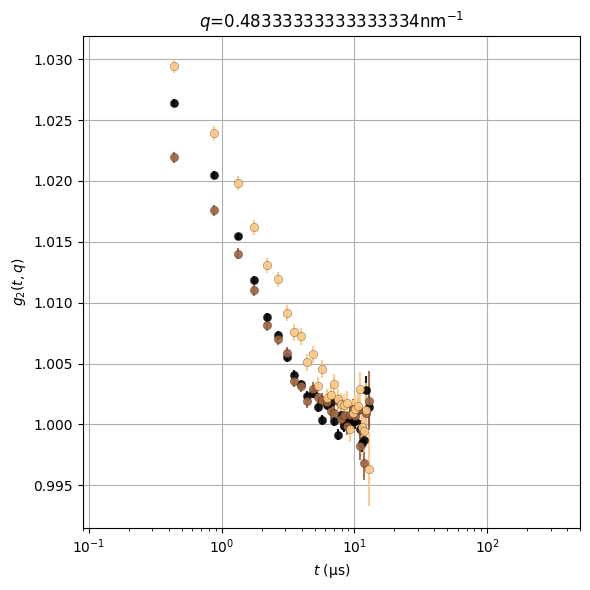

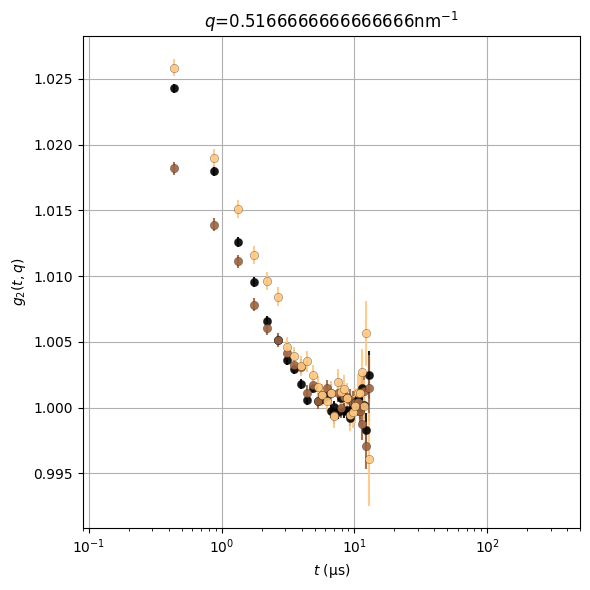

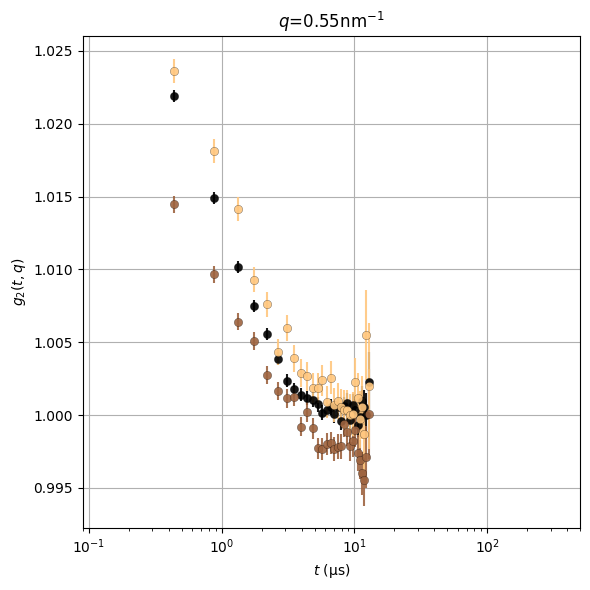

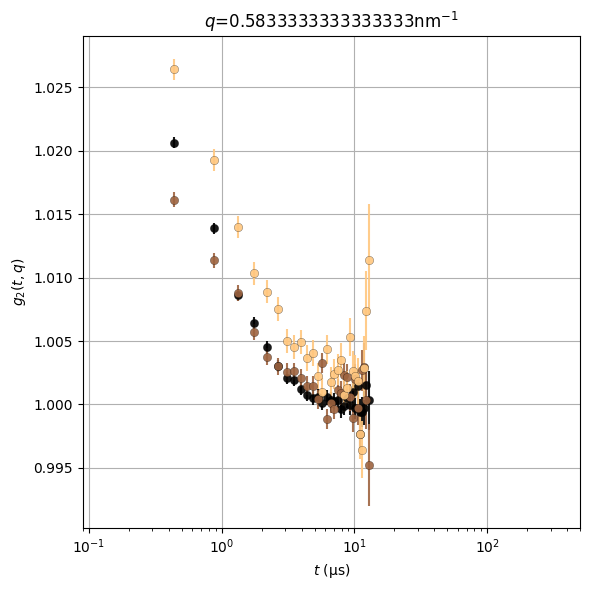

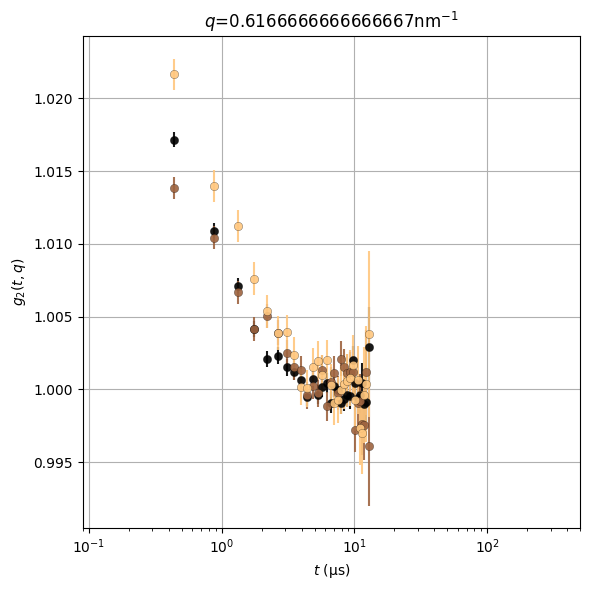

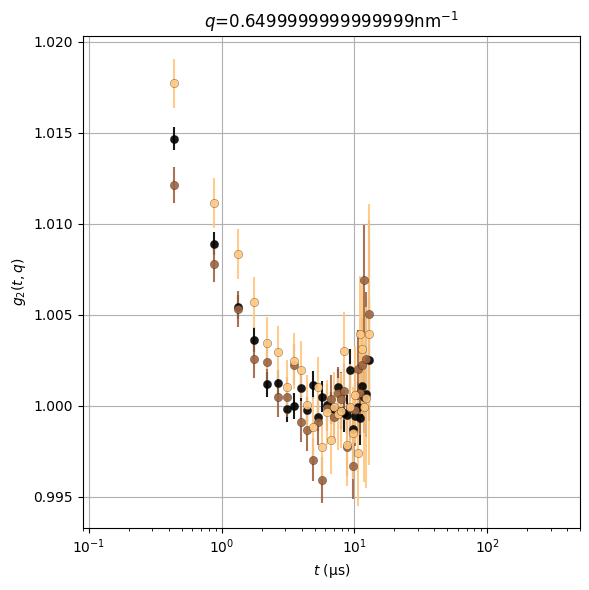

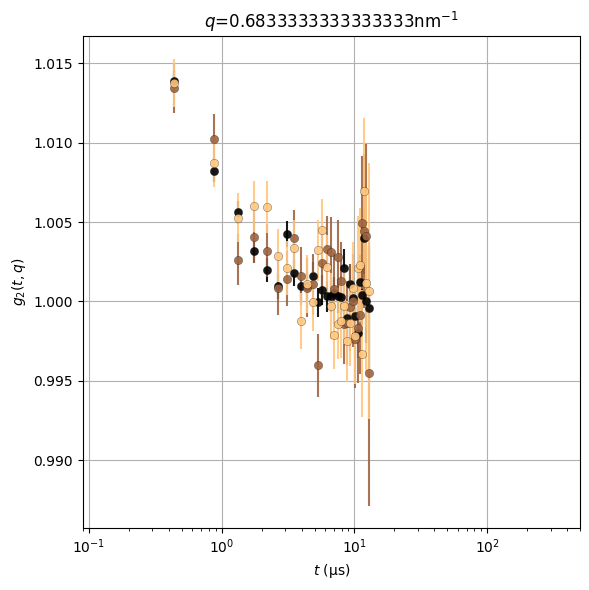

In [106]:
filenames=['c_70_abs2_RT_errorbars','c_70_abs1_RT_errorbars','c_70_absp6_RT_errorbars']
transmission=[2,1,.6]
concentration=[70,70,70]
bs=15e-6
qmin=0
qval=np.arange(15)
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))


tminframes=0
tmaxframes=30
plot_sameq(filenames,qval,tminframes,tmaxframes,weighted=1,baseline_correction=0)

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

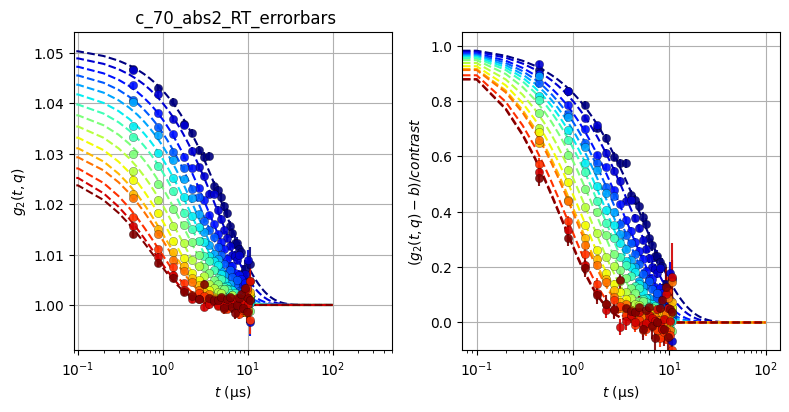

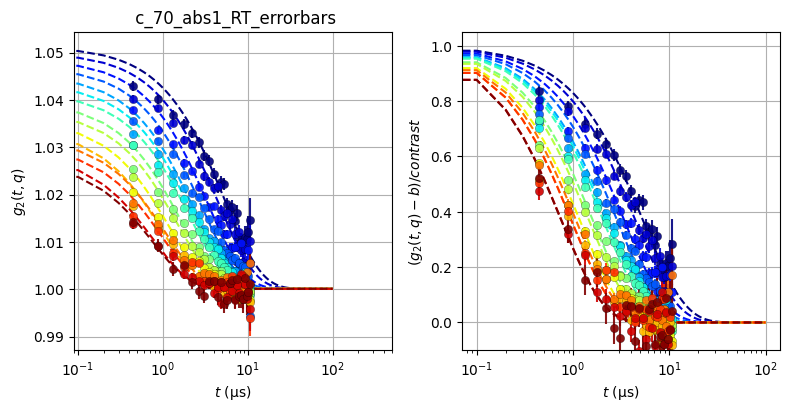

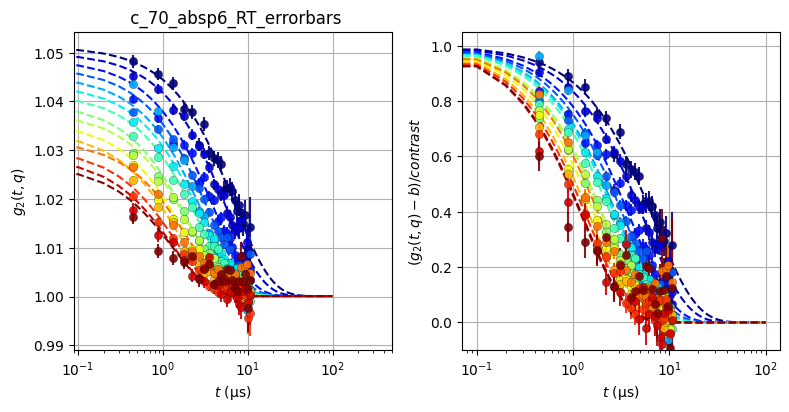

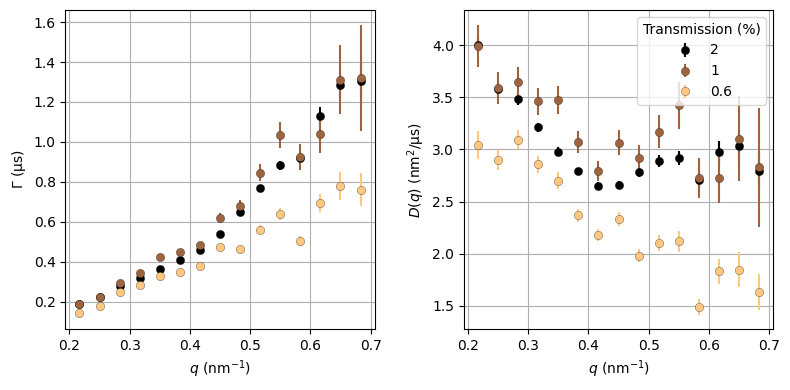

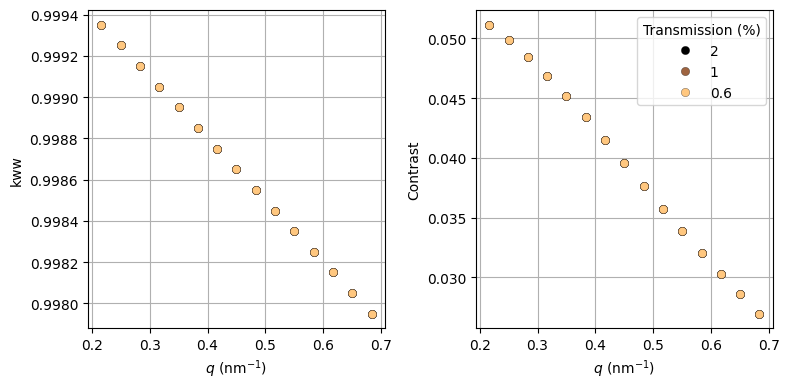

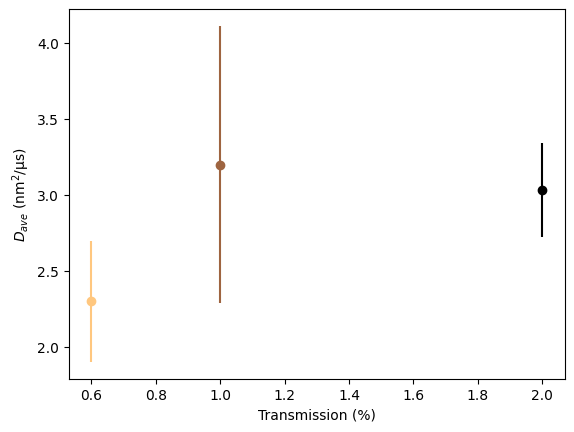

In [194]:
filenames=['c_70_abs2_RT_errorbars','c_70_abs1_RT_errorbars','c_70_absp6_RT_errorbars']
transmission=[2,1,.6]
concentration=[70,70,70]
bs=15e-6
qmin=0
qmax=15
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))


tminframes=0
tmaxframes=25

beamsize=[14.5e-6,14.5e-6,14.5e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0)


plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],A[i]*contrast,
    marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(transmission[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_files[i])
plt.xlabel('Transmission (%)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')





# fit g2 60 mg/ml  23C different attenuations

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

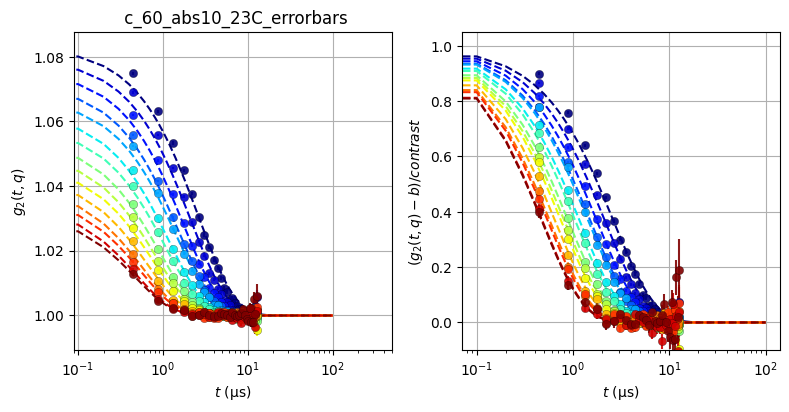

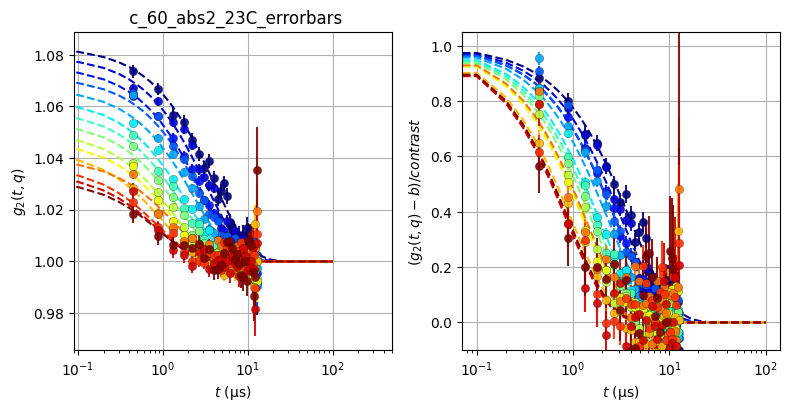

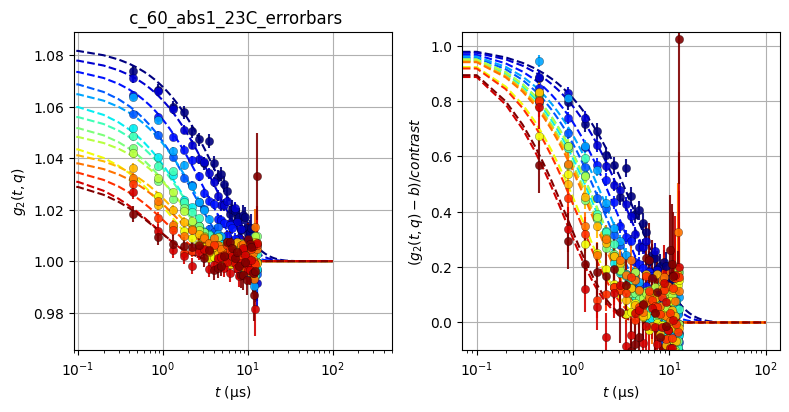

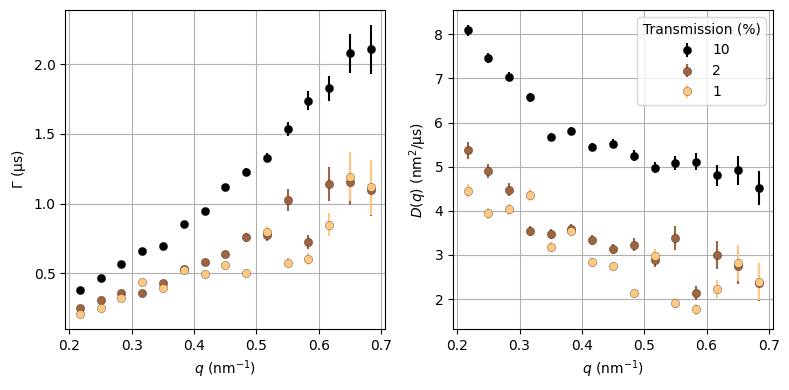

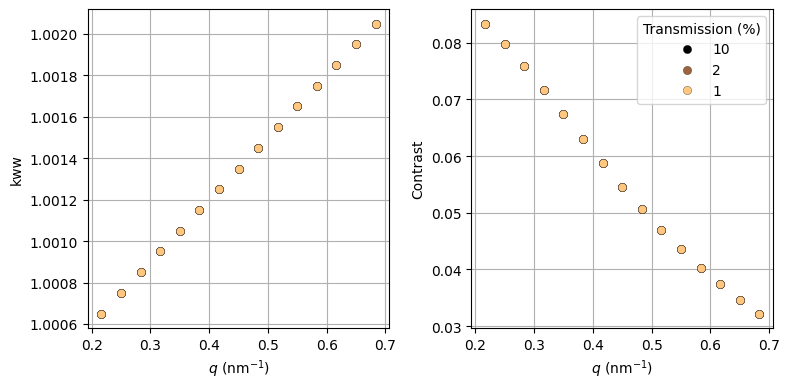

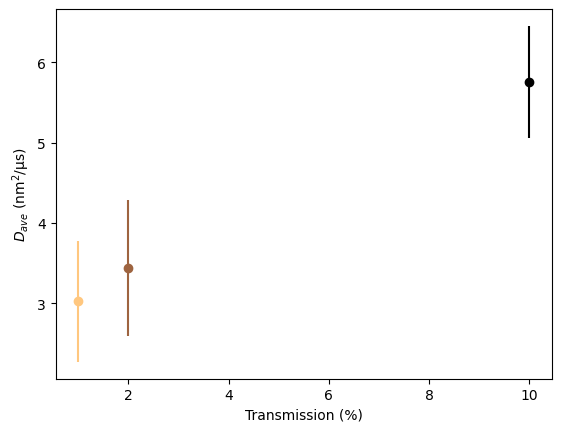

In [196]:
filenames=['c_60_abs10_23C_errorbars','c_60_abs2_23C_errorbars','c_60_abs1_23C_errorbars']
transmission=[10,2,1]
concentration=[60,60,60,60]
bs=15e-6


tminframes=0
tmaxframes=30
qmin=0
qmax=15
beamsize=[11e-6,11e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0 )

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],A[i]*contrast,marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(transmission[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_files[i])
plt.xlabel('Transmission (%)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')




# fit g2 60 mg/ml  0C different attenuations

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

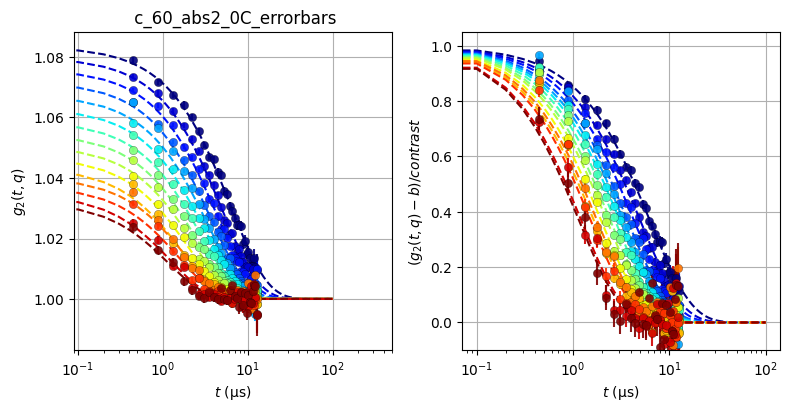

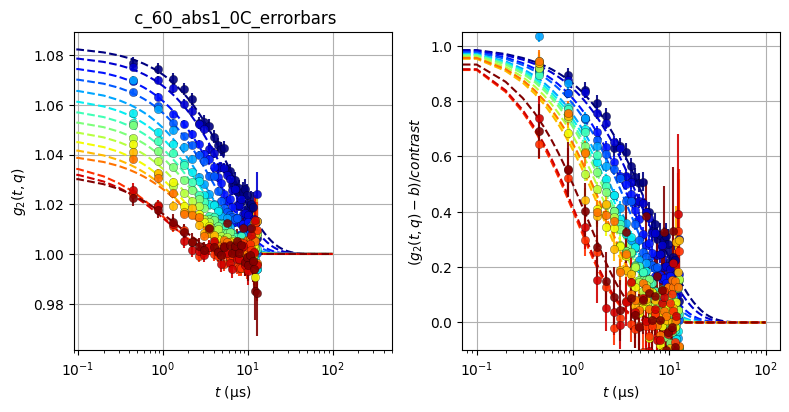

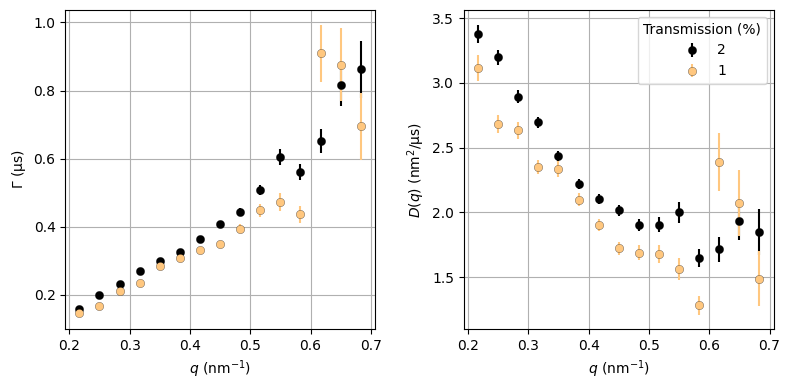

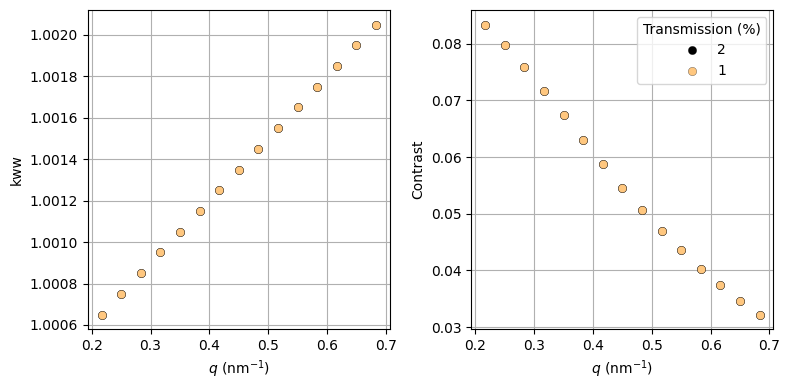

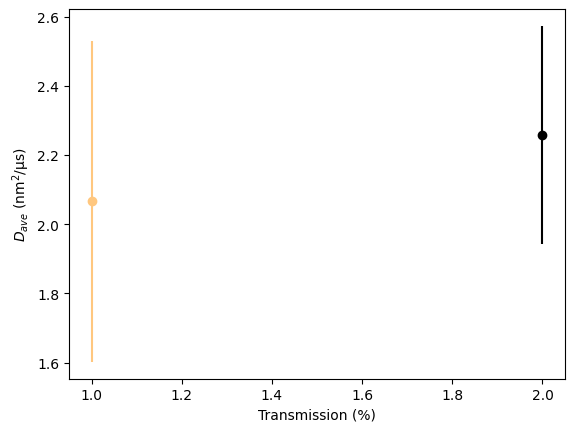

In [197]:
filenames=['c_60_abs2_0C_errorbars','c_60_abs1_0C_errorbars']#,'c_60_absp6_23C_errorbars']
transmission=[2,1,0.6]
concentration=[60,60,60,60]
bs=15e-6


tminframes=0
tmaxframes=30
qmin=0
qmax=15
beamsize=[11e-6,11e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0 )

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],A[i]*contrast,marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(transmission[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_files[i])
plt.xlabel('Transmission (%)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')




# fit g2 60 mg/ml  -20C different attenuations

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

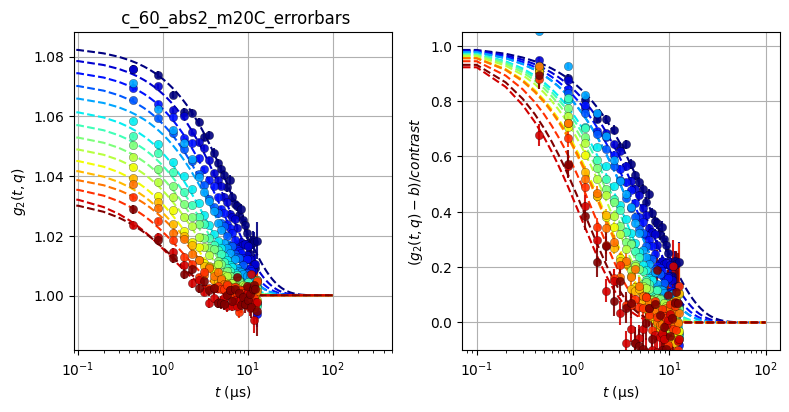

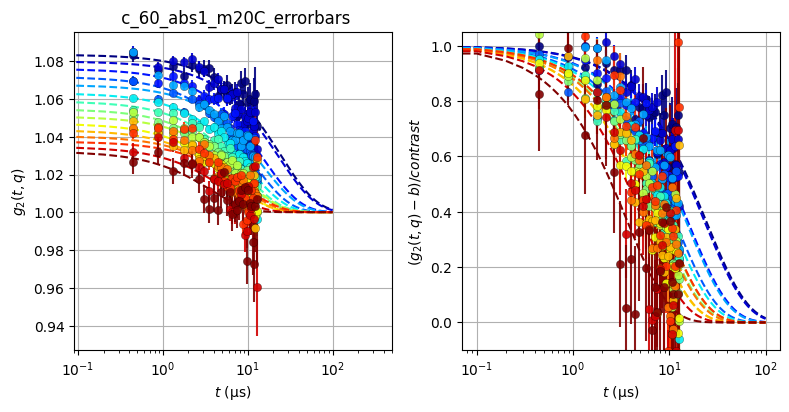

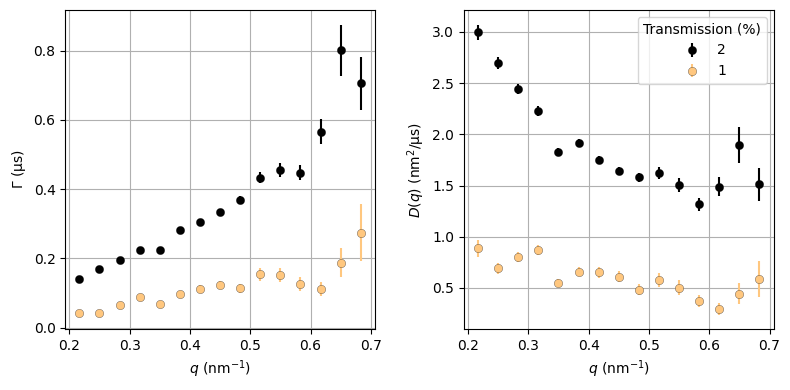

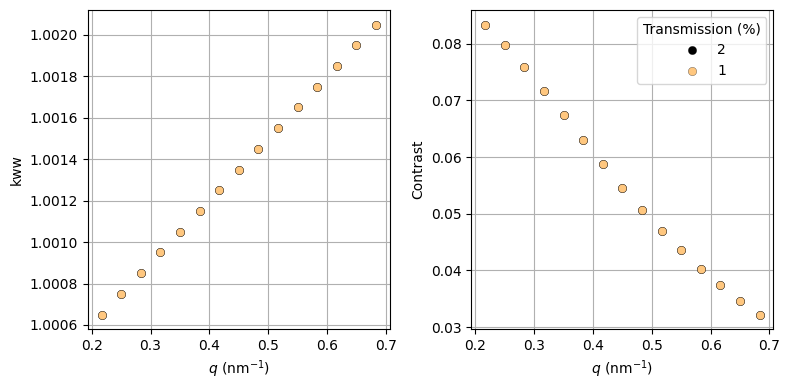

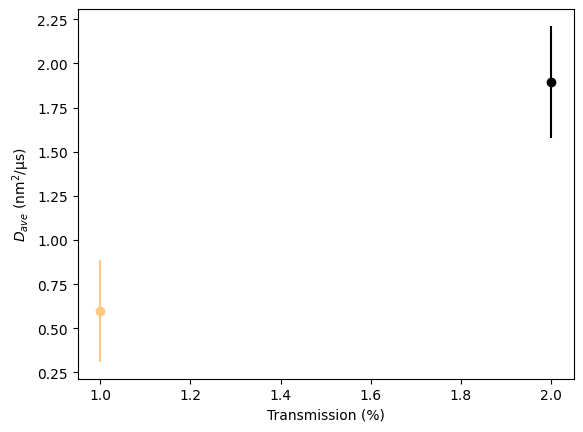

In [198]:
filenames=['c_60_abs2_m20C_errorbars','c_60_abs1_m20C_errorbars']#,'c_60_absp6_23C_errorbars']
transmission=[2,1,0.6]
concentration=[60,60,60,60]
bs=15e-6


tminframes=0
tmaxframes=30
qmin=0
qmax=15
beamsize=[11e-6,11e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0 )

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],A[i]*contrast,marker='o',ls='',color=colore_files[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(transmission,title='Transmission (%)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(transmission[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_files[i])
plt.xlabel('Transmission (%)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')




# fit g2 different concentration

## abs 1

Text(0, 0.5, '$D_{ave}/D_0$ ')

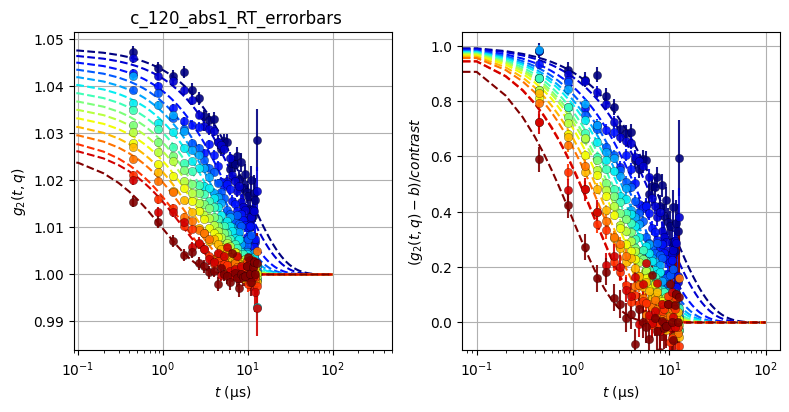

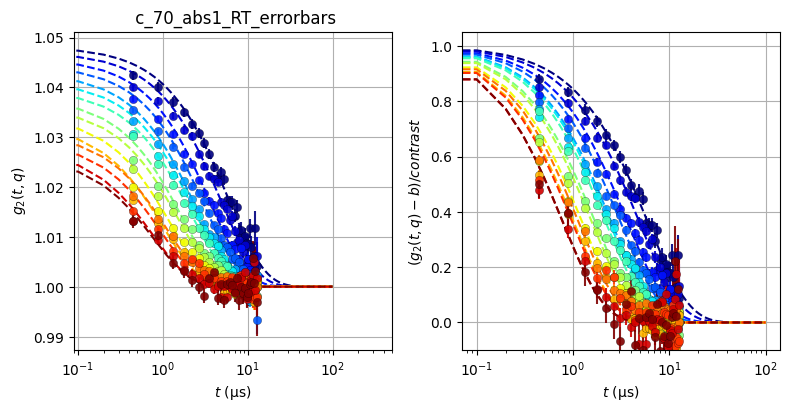

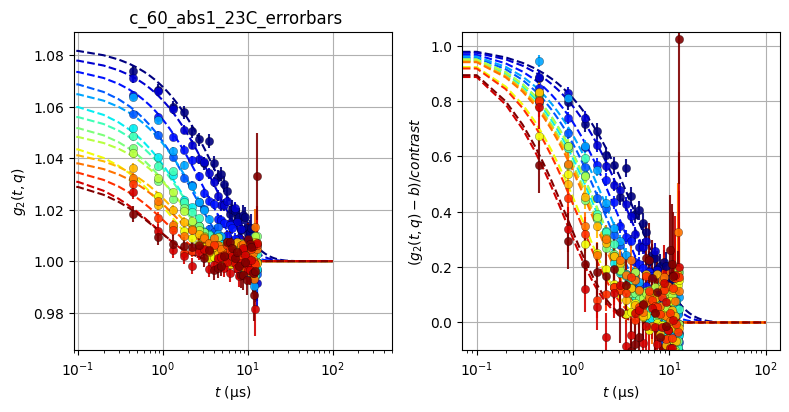

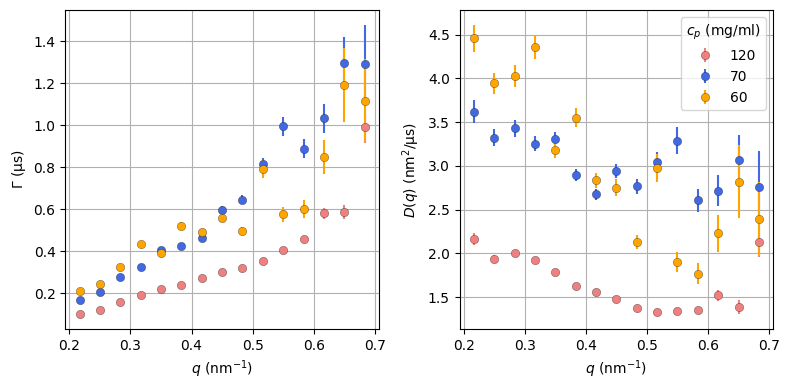

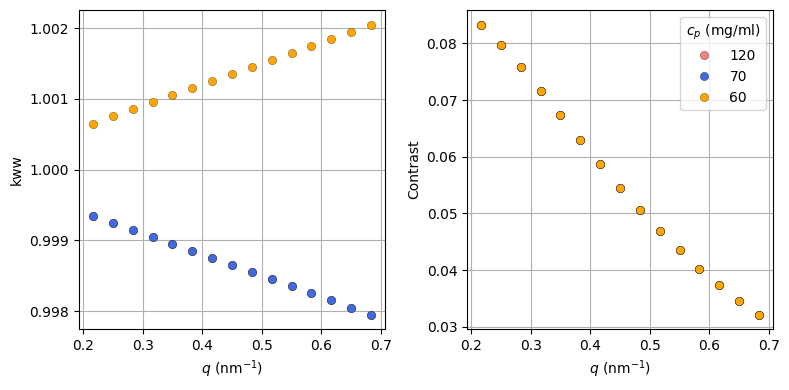

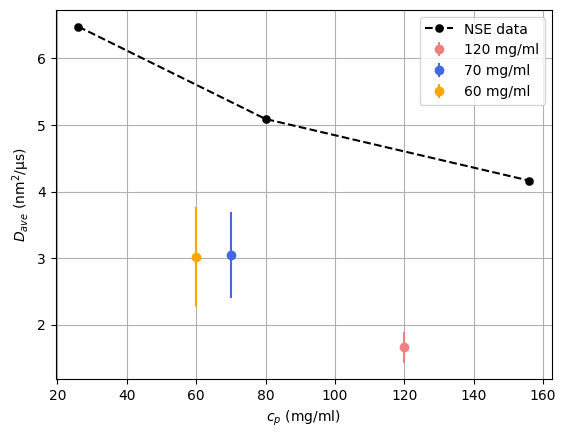

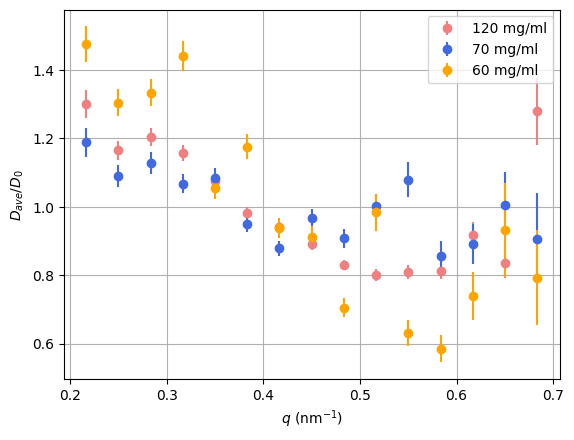

In [199]:
filenames=['c_120_abs1_RT_errorbars','c_70_abs1_RT_errorbars','c_60_abs1_23C_errorbars']#,'c_15_abs2_RT_errorbars',
transmission=[2,2,2,2]
concentration=np.array([120,70,60,15])
specific_volume=0.465e3 #ml mg−1

conc_NSE=np.array([26,80,156])
viscosity_with_gly=0.0053853
viscosity_d2o=0.001246

D_NSE=np.array([2.8,2.2,1.8])*10*viscosity_d2o/viscosity_with_gly

volume_fraction=concentration/specific_volume

qmin=0
qmax=15

tminframes=0
tmaxframes=30

beamsize=[15e-6,15e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0)

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))
colore_concentration=['lightcoral','royalblue','orange','forestgreen']


plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(concentration,title='$c_p$ (mg/ml)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')



plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],contrast,
    marker='o',ls='',color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(concentration,title='$c_p$ (mg/ml)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(concentration[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_concentration[i],label=f'{concentration[i]} mg/ml')
plt.plot(conc_NSE,D_NSE,marker='o',ls='dashed',
    color='black',markeredgewidth=.2,markeredgecolor='black',label='NSE data')
plt.legend()
plt.xlabel('$c_p$ (mg/ml)')
plt.grid('on')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')



plt.figure()
for i in range(len(filenames)):
    plt.errorbar(qvalues,D[i,:]/np.mean(D[i,:]),dD[i,:]/np.mean(D[i,:]),marker='o',ls='',color=colore_concentration[i],label=f'{concentration[i]} mg/ml')
plt.legend()
plt.xlabel('$q$ (nm$^{-1}$)')
plt.grid('on')
plt.ylabel('$D_{ave}/D_0$ ')



## abs 2

Text(0, 0.5, '$D_{ave}/D_0$ ')

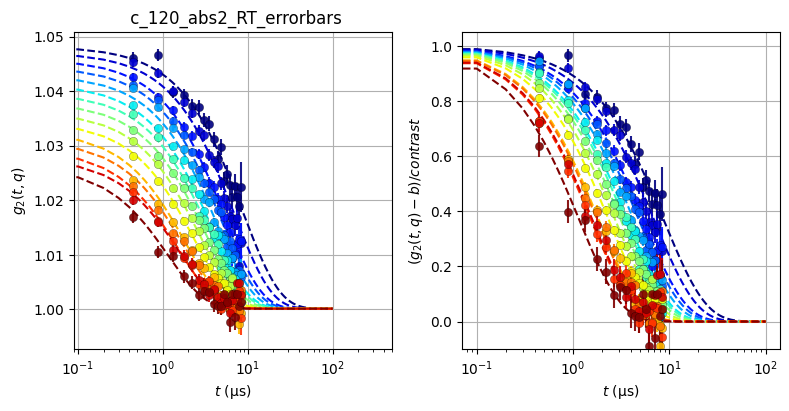

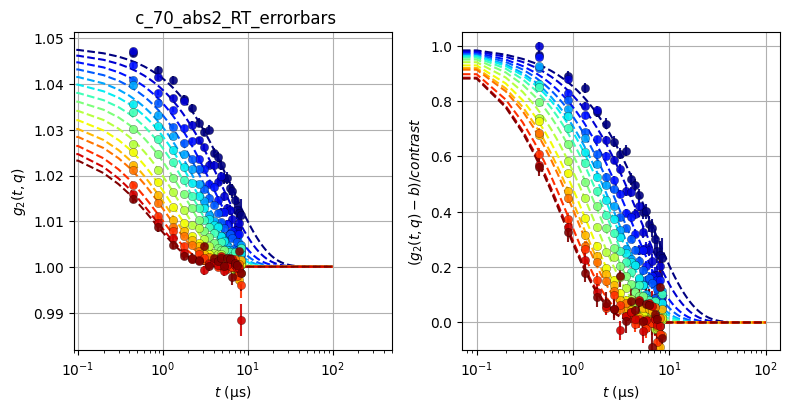

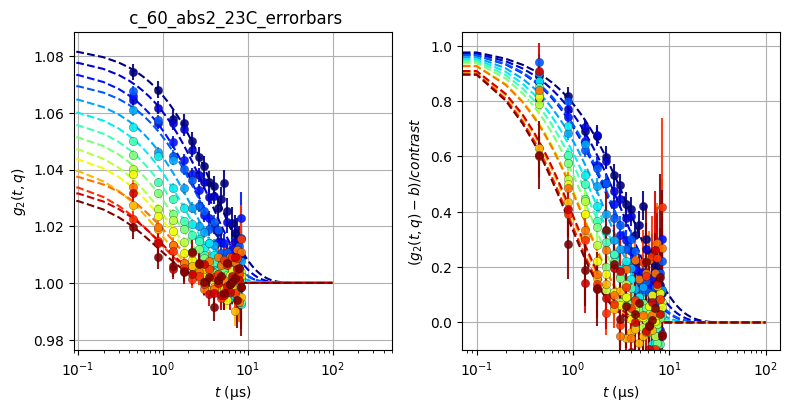

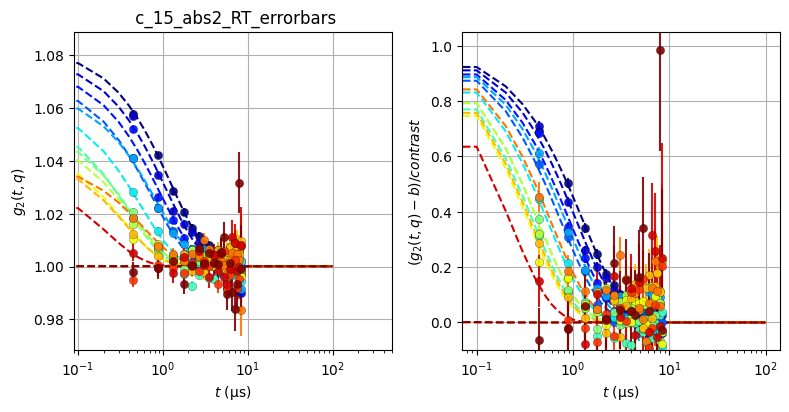

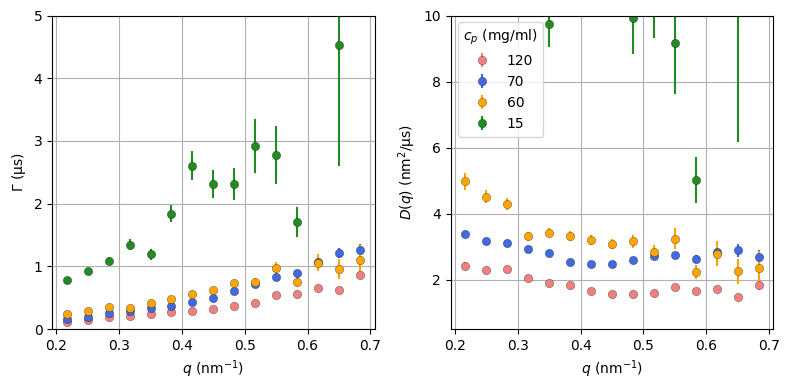

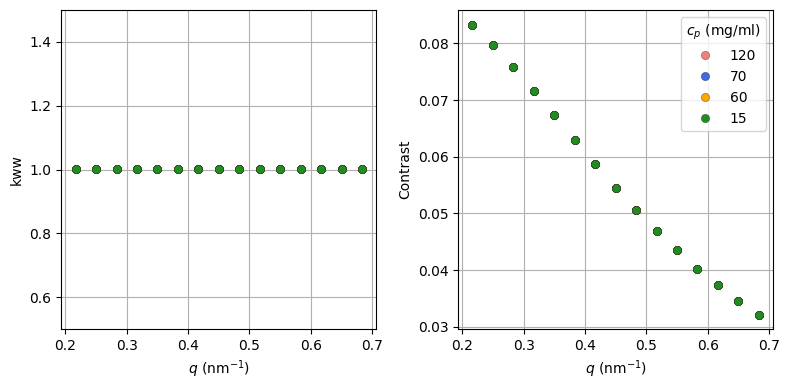

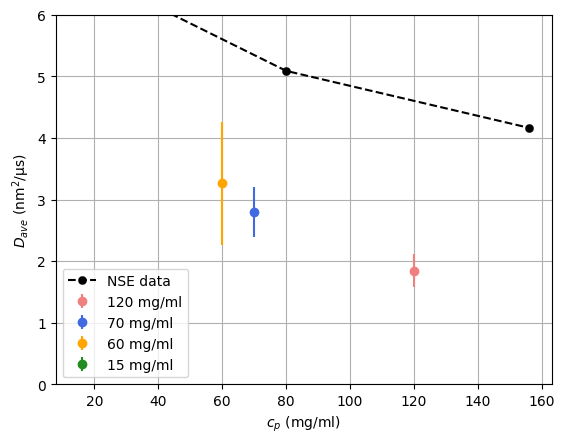

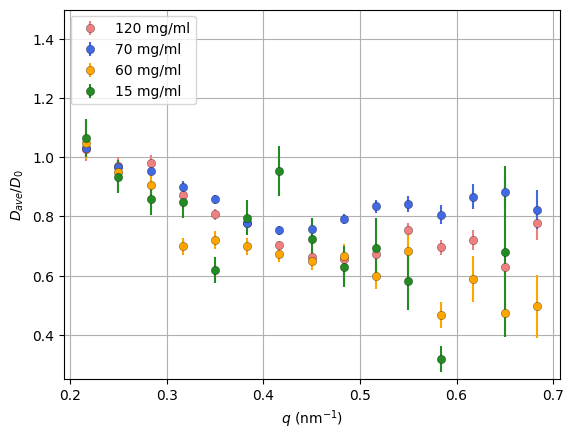

In [203]:
filenames=['c_120_abs2_RT_errorbars','c_70_abs2_RT_errorbars','c_60_abs2_23C_errorbars','c_15_abs2_RT_errorbars']#,'c_15_abs2_RT_errorbars',
transmission=[2,2,2,2]
concentration=np.array([120,70,60,15])
specific_volume=0.465e3 #ml mg−1

conc_NSE=np.array([26,80,156])
viscosity_with_gly=0.0053853
viscosity_d2o=0.001246

D_NSE=np.array([2.8,2.2,1.8])*10*viscosity_d2o/viscosity_with_gly

volume_fraction=concentration/specific_volume

qmin=0
qmax=15

tminframes=0
tmaxframes=20

beamsize=[15e-6,15e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0)

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))
colore_concentration=['lightcoral','royalblue','orange','forestgreen']


plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()
    plt.ylim([0, 5])
    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.ylim([0.5, 10])
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(concentration,title='$c_p$ (mg/ml)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')



plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    plt.ylim([0.5, 1.5])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],contrast,
    marker='o',ls='',color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(concentration,title='$c_p$ (mg/ml)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(concentration[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_concentration[i],label=f'{concentration[i]} mg/ml',markeredgewidth=.2,markeredgecolor='black',)
plt.plot(conc_NSE,D_NSE,marker='o',ls='dashed',
    color='black',markeredgewidth=.2,markeredgecolor='black',label='NSE data')
plt.legend()
plt.ylim([0, 6])
plt.xlabel('$c_p$ (mg/ml)')
plt.grid('on')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')



plt.figure()
for i in range(len(filenames)):
     plt.errorbar(qvalues,D[i,:]/np.mean(D[i,:2]),dD[i,:]/np.mean(D[i,:2]),marker='o',ls='',color=colore_concentration[i],label=f'{concentration[i]} mg/ml',markeredgewidth=.2,markeredgecolor='black',)
plt.legend()
plt.xlabel('$q$ (nm$^{-1}$)')
plt.grid('on')
plt.ylim([0.25, 1.5])
plt.ylabel('$D_{ave}/D_0$ ')



## abs 10


Text(0, 0.5, '$D_{ave}/D_0$ ')

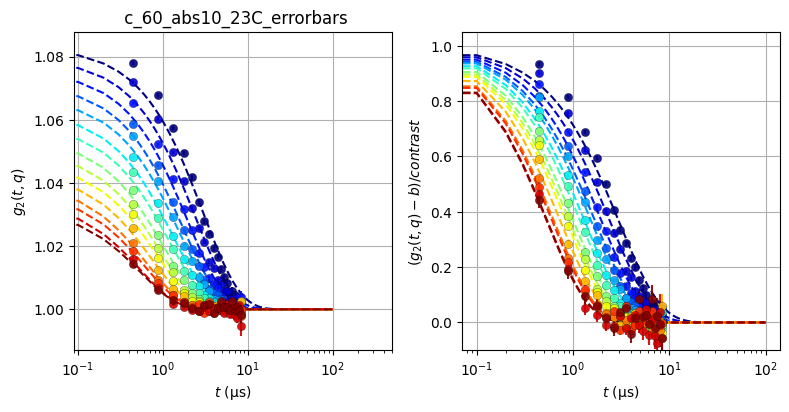

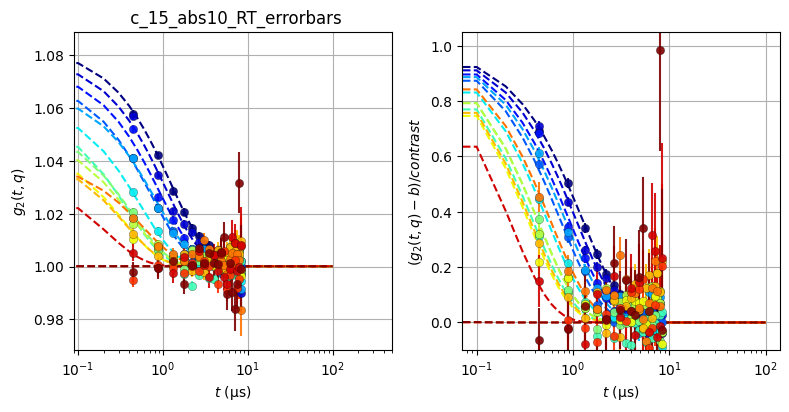

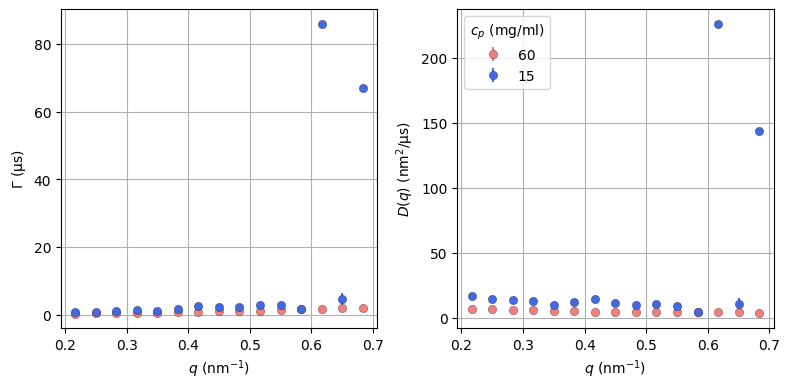

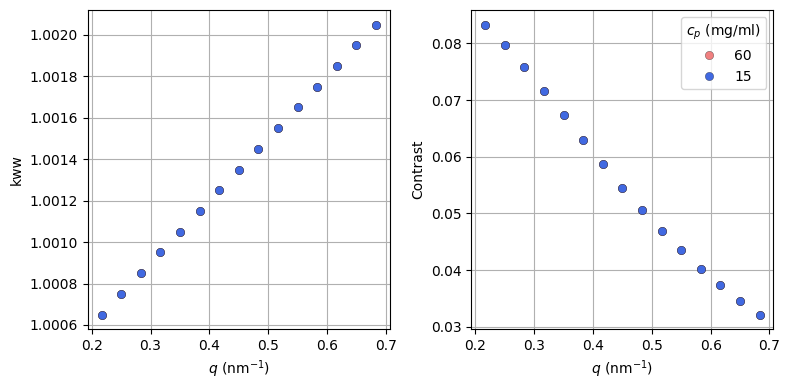

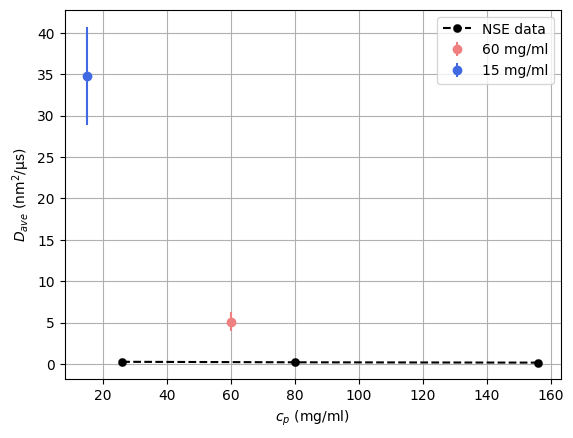

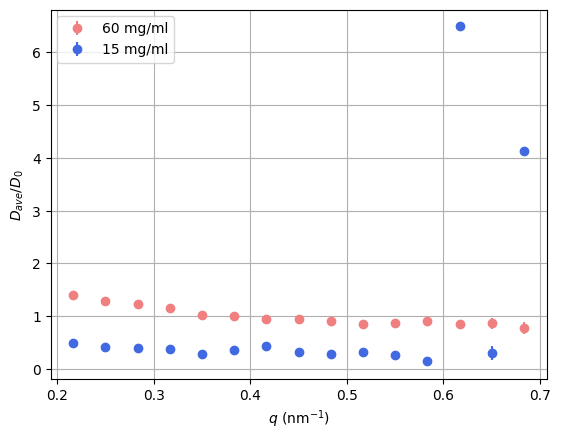

In [201]:
filenames=['c_60_abs10_23C_errorbars','c_15_abs10_RT_errorbars']#,,
transmission=[10,10]
concentration=np.array([60,15])
specific_volume=0.465e3 #ml mg−1

conc_NSE=np.array([26,80,156])
D_NSE=np.array([2.8,2.2,1.8])*.1

volume_fraction=concentration/specific_volume

qmin=0
qmax=15

tminframes=0
tmaxframes=20

beamsize=[11e-6,11e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0)

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))
colore_concentration=['lightcoral','royalblue','orange','forestgreen']


plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(concentration,title='$c_p$ (mg/ml)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')



plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],contrast,
    marker='o',ls='',color=colore_concentration[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(concentration,title='$c_p$ (mg/ml)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(concentration[i],np.mean(D[i,:]),np.sqrt(sum(dD[i,:]**2)),marker='o',ls='',color=colore_concentration[i],label=f'{concentration[i]} mg/ml')
plt.plot(conc_NSE,D_NSE,marker='o',ls='dashed',
    color='black',markeredgewidth=.2,markeredgecolor='black',label='NSE data')
plt.legend()
plt.xlabel('$c_p$ (mg/ml)')
plt.grid('on')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')



plt.figure()
for i in range(len(filenames)):
    plt.errorbar(qvalues,D[i,:]/np.mean(D[i,:]),dD[i,:]/np.mean(D[i,:]),marker='o',ls='',color=colore_concentration[i],label=f'{concentration[i]} mg/ml')
plt.legend()
plt.xlabel('$q$ (nm$^{-1}$)')
plt.grid('on')
plt.ylabel('$D_{ave}/D_0$ ')



# fit g2 different temperature

## abs 1

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

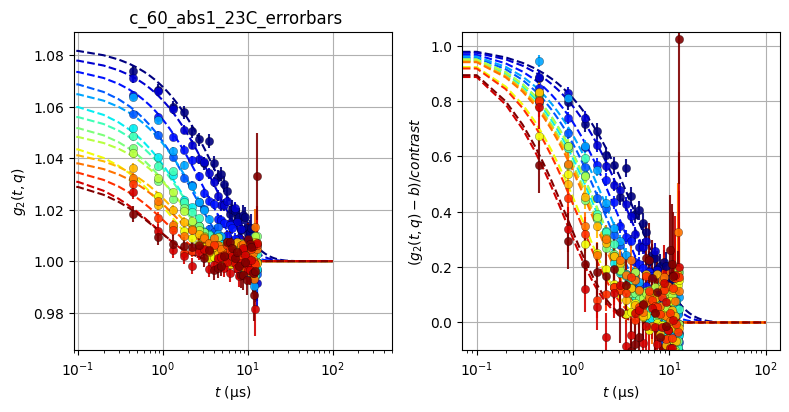

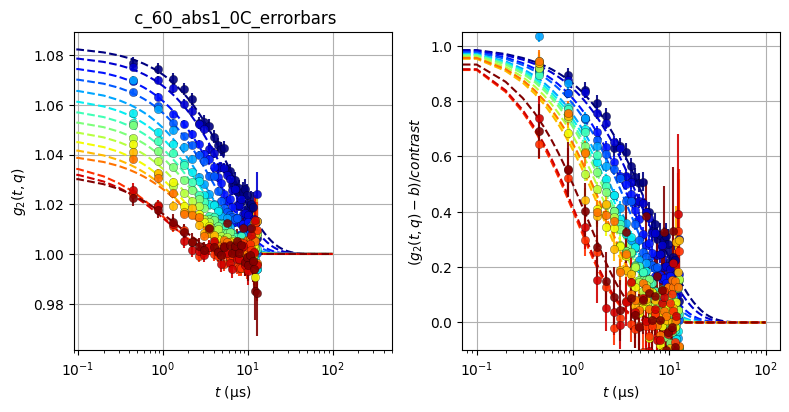

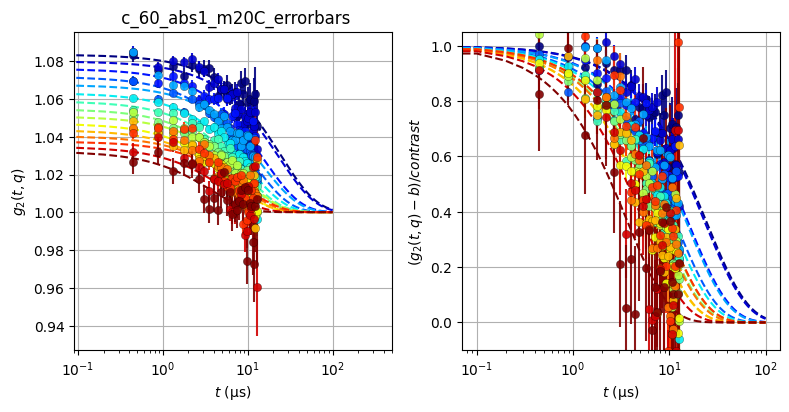

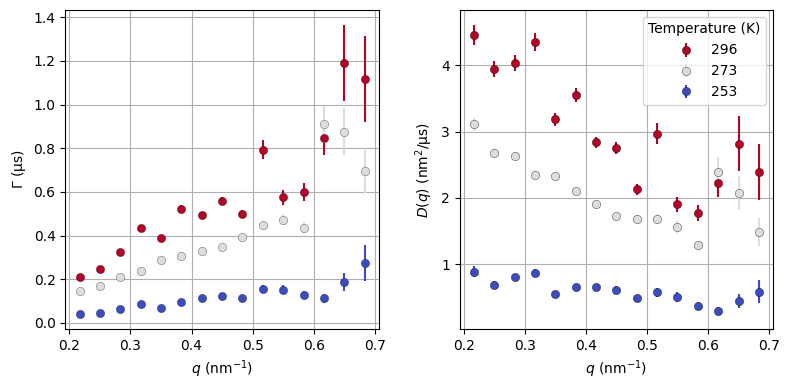

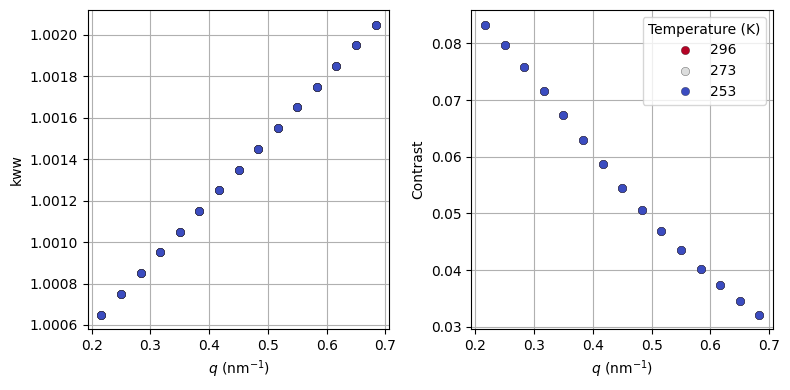

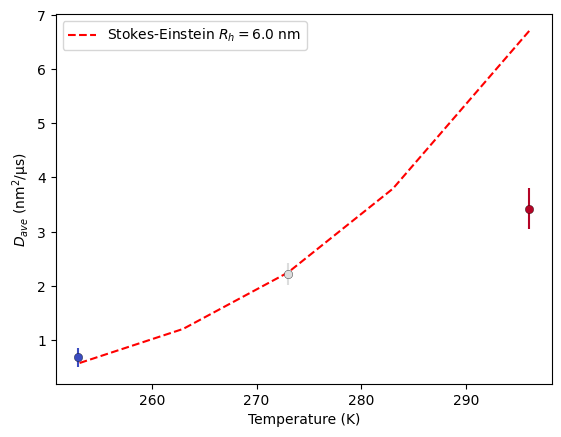

In [164]:
filenames=['c_60_abs1_23C_errorbars','c_60_abs1_0C_errorbars','c_60_abs1_m20C_errorbars']#
transmission=[2,2,2]
concentration=[60,60,60]
temperature=np.array([296,273,253])
temp_4plot=np.array([296,283,273,263,253])
viscosity_solvent=np.array([0.0053853,0.0091039,0.014837,0.026676,0.054603])
viscosity_d20=np.array([0.001246])


bs=11e-6
k_b=1.38e-23
R_h=6e-9

qmin=0
qmax=15

tminframes=0
tmaxframes=30

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))
colore_temperature=plt.cm.coolwarm_r(np.linspace(0,1,len(temperature)))

beamsize=[11e-6,11e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=0)

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_temperature[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_temperature[i],markeredgewidth=.25,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(temperature,title='Temperature (K)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_temperature[i],markeredgewidth=.25,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],contrast,
    marker='o',ls='',color=colore_temperature[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(temperature,title='Temperature (K)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(temperature[i],np.mean(D[i,:10]),np.sqrt(sum(dD[i,:10]**2)),marker='o',ls='',color=colore_temperature[i],markeredgewidth=.25,markeredgecolor='black')
plt.plot(temp_4plot,k_b*temp_4plot/(viscosity_solvent*6*np.pi*R_h)*1e18/1e6,color='red',label='Stokes-Einstein $R_h=$'+str(R_h*10**9)+' nm',ls='dashed')

plt.legend()

plt.xlabel('Temperature (K)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')





## abs2

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

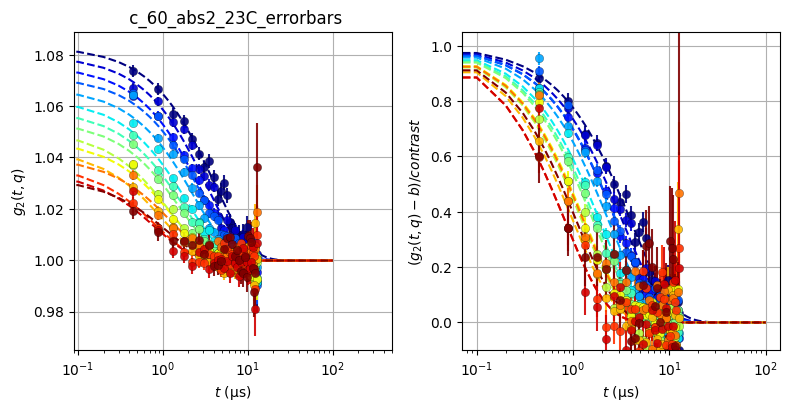

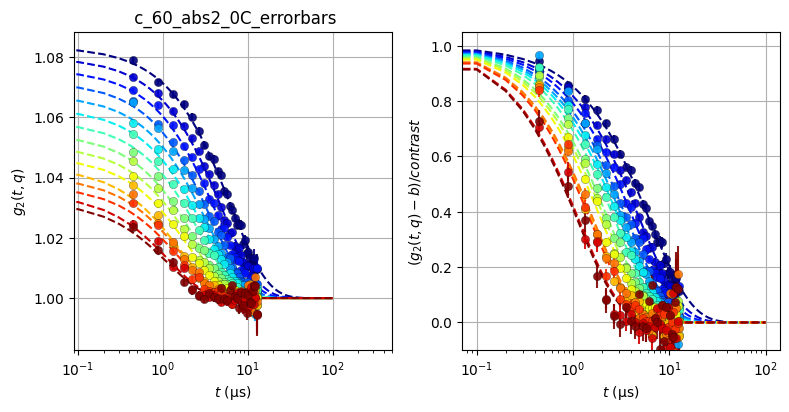

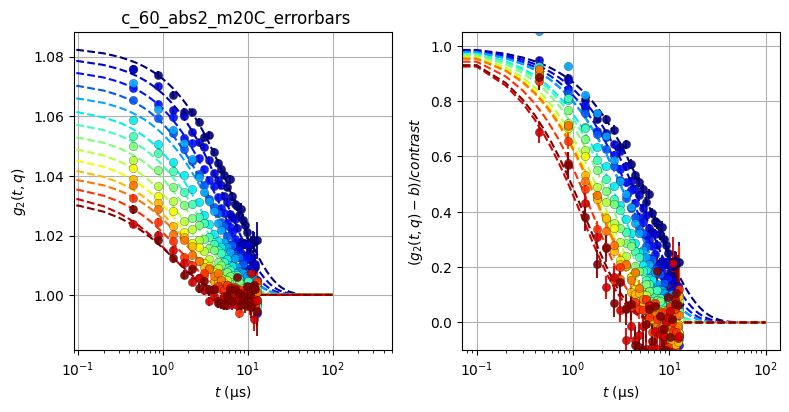

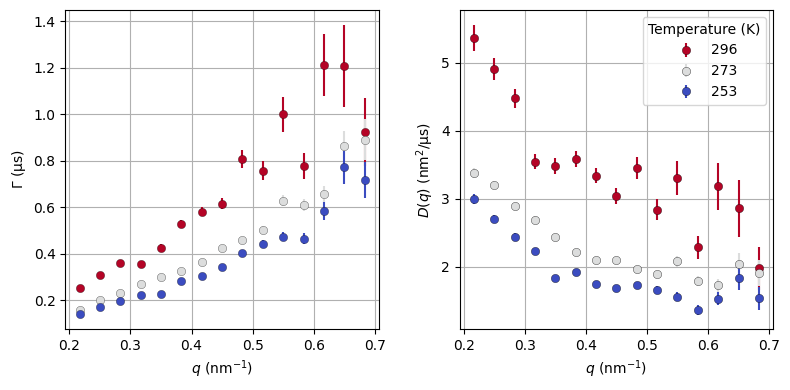

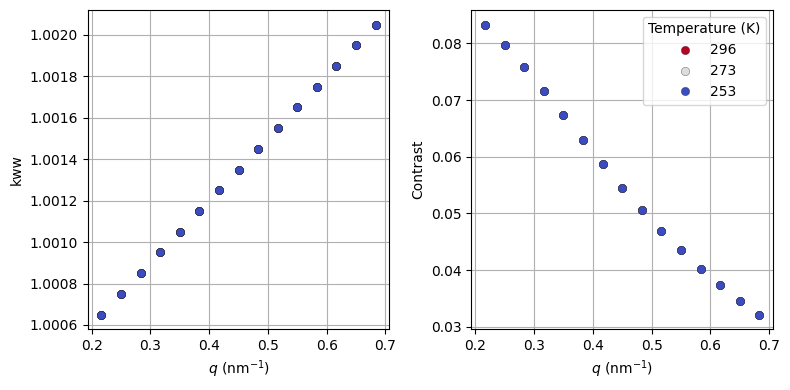

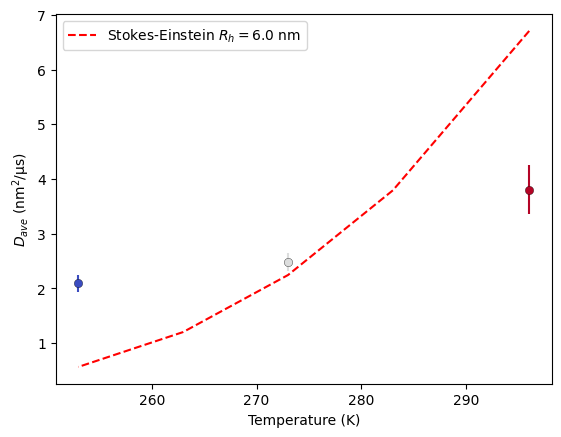

In [167]:
filenames=['c_60_abs2_23C_errorbars','c_60_abs2_0C_errorbars','c_60_abs2_m20C_errorbars']
transmission=[2,2,2]
concentration=[60,60,60]
temperature=np.array([296,273,253])
temp_4plot=np.array([296,283,273,263,253])
viscosity_solvent=np.array([0.0053853,0.0091039,0.014837,0.026676,0.054603])
bs=11e-6
k_b=1.38e-23
R_h=6e-9

qmin=0
qmax=15

tminframes=0
tmaxframes=30

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_files=plt.cm.copper(np.linspace(0,1,len(filenames)))
colore_temperature=plt.cm.coolwarm_r(np.linspace(0,1,len(temperature)))

beamsize=[11e-6,11e-6,11e-6,11e-6]
qvalues, A, kww, baseline, tau, D,contrast, dA, dkww, dbaseline, dD, dtau=fit3D(filenames,beamsize,qmin,qmax,tminframes,tmaxframes,weighted=1,baseline_correction=1)

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_temperature[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_temperature[i],markeredgewidth=.25,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(temperature,title='Temperature (K)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(len(filenames)):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_temperature[i],markeredgewidth=.25,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],contrast,
    marker='o',ls='',color=colore_temperature[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(temperature,title='Temperature (K)')
    plt.ylabel('Contrast')

plt.figure()
for i in range(len(filenames)):
    plt.errorbar(temperature[i],np.mean(D[i,:10]),np.sqrt(sum(dD[i,:10]**2)),marker='o',ls='',color=colore_temperature[i],markeredgewidth=.25,markeredgecolor='black')
plt.plot(temp_4plot,k_b*temp_4plot/(viscosity_solvent*6*np.pi*R_h)*1e18/1e6,color='red',label='Stokes-Einstein $R_h=$'+str(R_h*10**9)+' nm',ls='dashed')

plt.legend()

plt.xlabel('Temperature (K)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')





# chech ttcs and errorbars on ttc

In [ ]:

filenames=['c_60_abs1_m20C_errorbars']
colore=plt.cm.jet(np.linspace(0,1,len(filenames)))

t_delay=.44
q=13
tot_frames=100

fig=plt.figure(figsize=(15,10))
for i,namefile in enumerate(filenames):
    data=np.load(f'{pathtodata}{namefile}.npz')
    ttcs=data['ttcs']
    err_ttcs=data['err_ttcs']
    
    qvalues=data['q']
    for q in range(15):
        plt.subplot(3,5,q+1)
        plt.imshow(err_ttcs[q,:,:],origin='lower',cmap='jet',extent=(t_delay,t_delay*tot_frames,t_delay,t_delay*tot_frames,),interpolation='none')
        plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
        plt.tight_layout()
        plt.ylabel('$t_2$ (μs)')
        plt.xlabel('$t_1$ (μs)')

        if q==14:

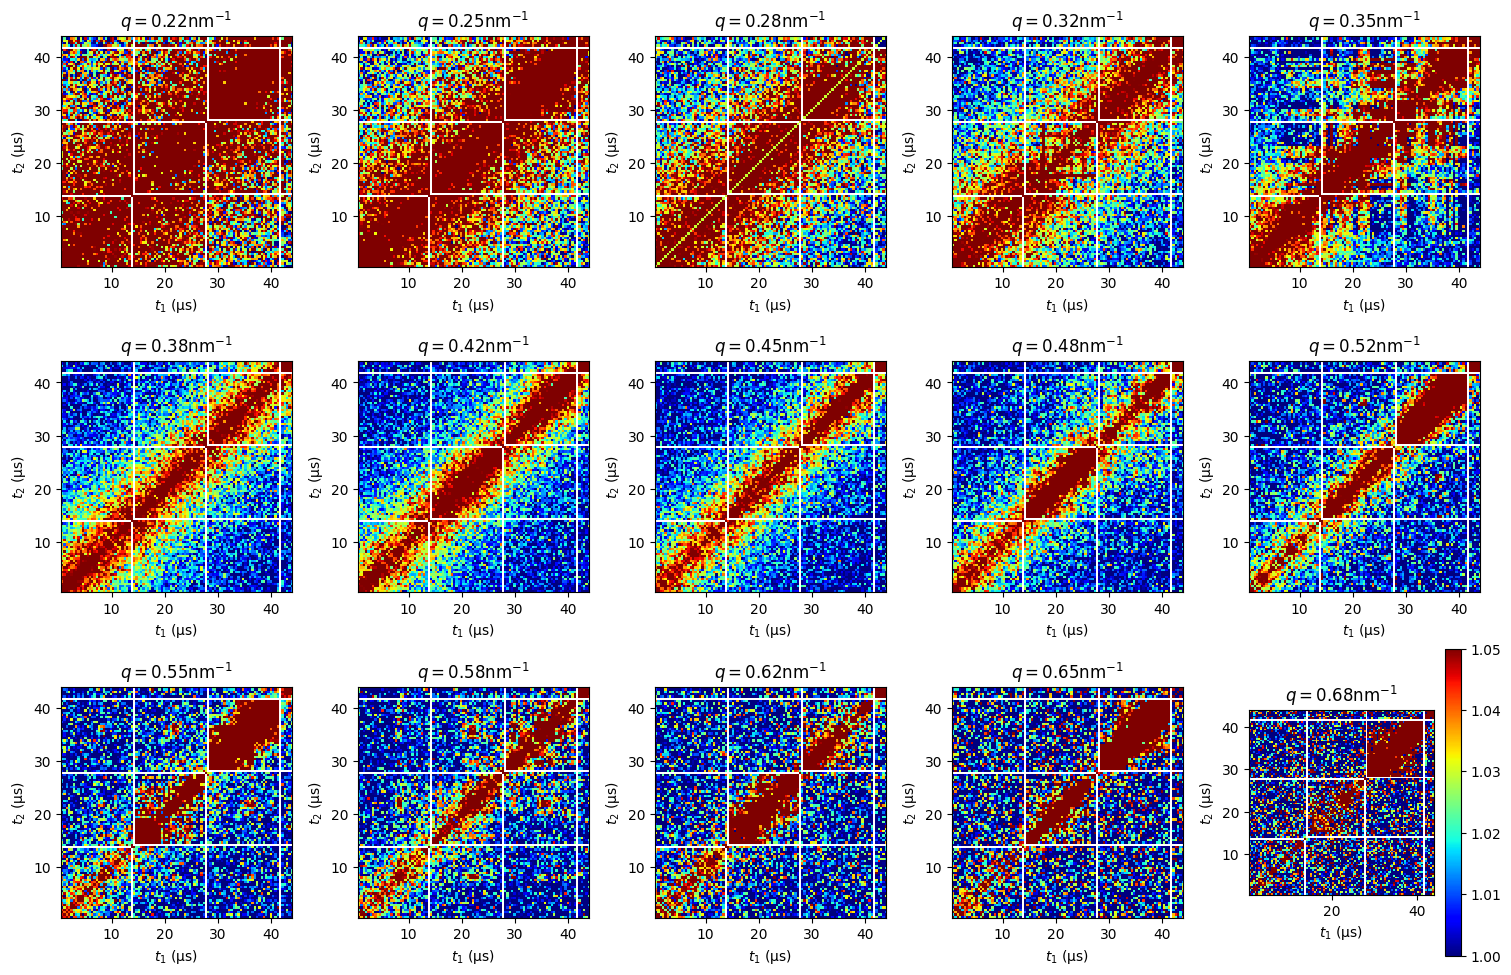

In [24]:

filenames=['c_60_abs1_m20C_errorbars']
colore=plt.cm.jet(np.linspace(0,1,len(filenames)))

t_delay=.44
q=13
tot_frames=100

fig=plt.figure(figsize=(15,10))
for i,namefile in enumerate(filenames):
    data=np.load(f'{pathtodata}{namefile}.npz')
    ttcs=data['ttcs']
    qvalues=data['q']
    for q in range(15):
        plt.subplot(3,5,q+1)
        plt.imshow(ttcs[q,:,:],origin='lower',cmap='jet',vmin=1,vmax=1.05,extent=(t_delay,t_delay*tot_frames,t_delay,t_delay*tot_frames,),interpolation='none')
        plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
        plt.tight_layout()
        plt.ylabel('$t_2$ (μs)')
        plt.xlabel('$t_1$ (μs)')

        if q==14:
            plt.colorbar()

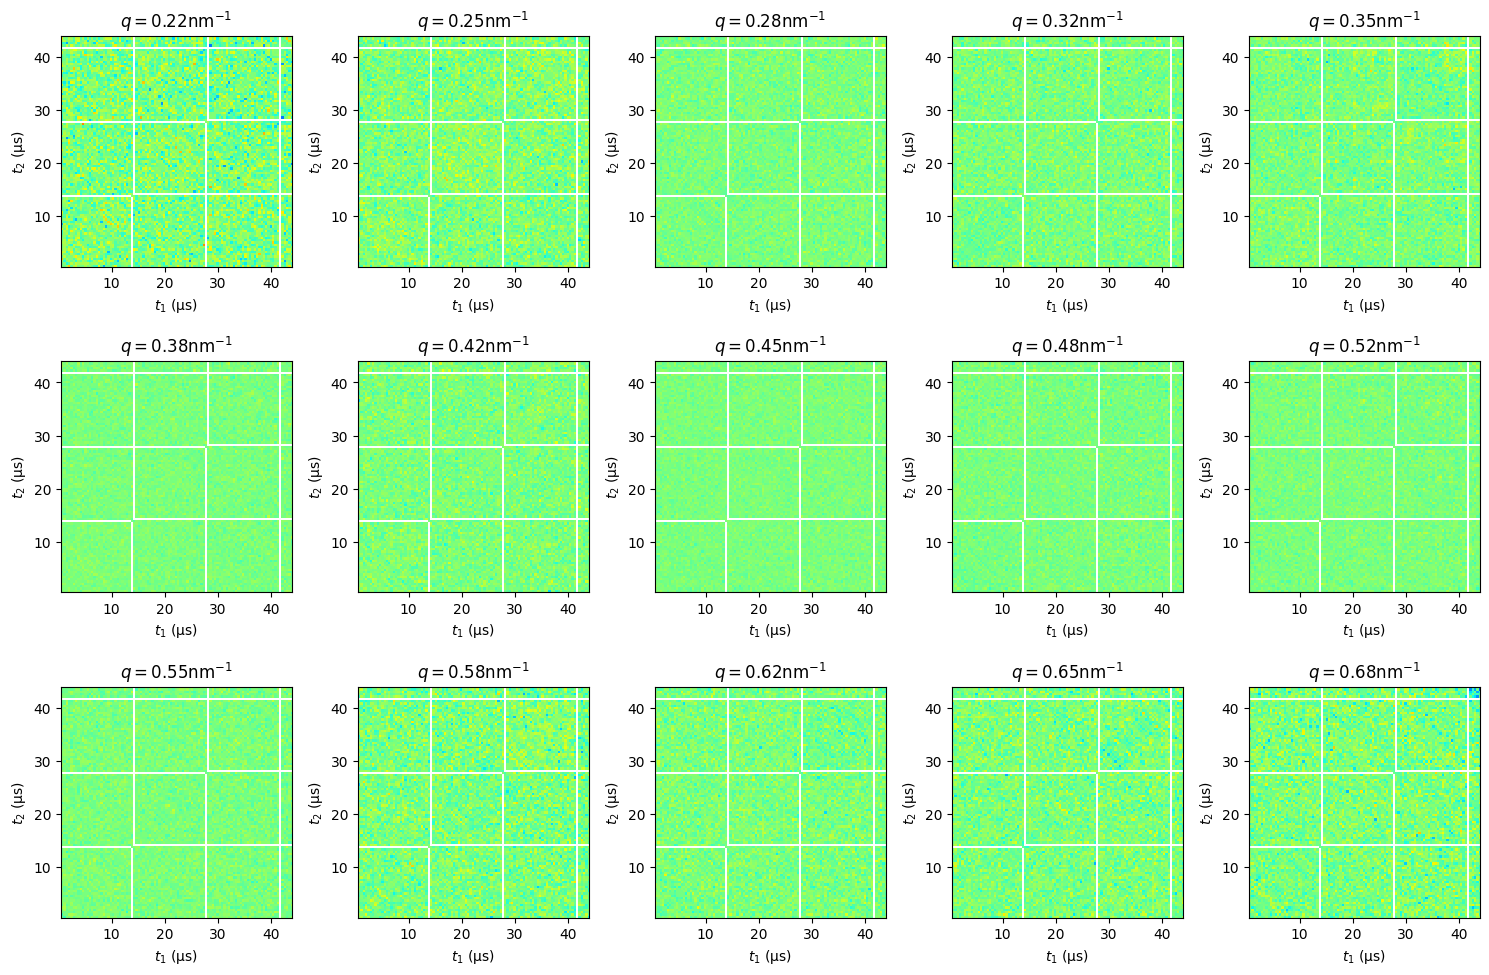

In [106]:

filename1='c_70_abs2_RT_errorbars'
filename2='c_70_abs2_RT'
colore=plt.cm.jet(np.linspace(0,1,len(filenames)))

t_delay=.44
q=13
tot_frames=100


data=np.load(f'{pathtodata}{filename1}.npz')
ttcs=data['ttcs']
qvalues=data['q']

data=np.load(f'{pathtodata}{filename2}.npz')
newttcs=data['ttcs']
qvalues=data['q']




fig=plt.figure(figsize=(15,10))
for q in range(15):
        plt.subplot(3,5,q+1)
        plt.imshow(ttcs[q,:,:]-newttcs[q,:,:],vmin=-0.01,vmax=0.01,origin='lower',cmap='jet',extent=(t_delay,t_delay*tot_frames,t_delay,t_delay*tot_frames,),interpolation='none')
        plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
        plt.tight_layout()
        plt.ylabel('$t_2$ (μs)')
        plt.xlabel('$t_1$ (μs)')


29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29


<Figure size 1500x1000 with 0 Axes>

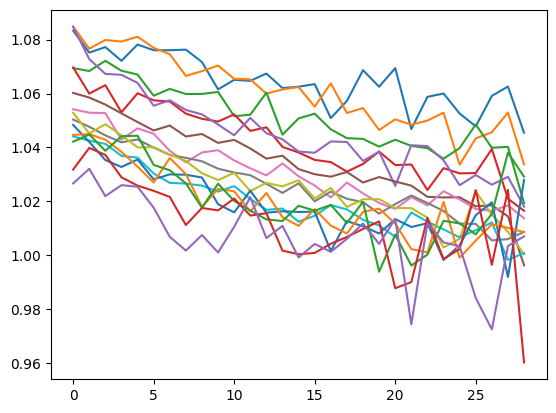

In [95]:

filenames=['c_60_abs1_m20C_errorbars']
colore=plt.cm.jet(np.linspace(0,1,len(filenames)))

t_delay=.44
q=13
tot_frames=100
t=np.arange(1,tmaxframes-tminframes)*t_delay


fig=plt.figure(figsize=(15,10))
for i,namefile in enumerate(filenames):
    data=np.load(f'{pathtodata}{namefile}.npz')
    ttcs=data['ttcs']
    qvalues=data['q']
plt.figure()
for q in range(qmax):
    g2,dg2=calculate_g2_weighted(ttcs[q,:30,:30],err_ttcs[q,:30,:30])
    plt.plot(g2)
    print(np.sum(np.array(g2)<np.infty))
    print(np.sum(np.array(dg2)<np.infty))
    

In [77]:
np.sum(ttcs[0,:,:]<1)



238